# Aim
Checking if centroids of overlapping optima of local subgraphs also maximize their parent graphs

## Basics

In [33]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
sys.path.append('home/egupta/.local/bin')

In [34]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import scipy.stats as ss
import networkx as nx
import csv 
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import pyplot as plt
#clustering
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline


##qtensor imports
import qtensor
from qtensor import QAOA_energy
from qtensor import parameter_optimization as popt

In [35]:
import torch

# Subgraphs Code

In [36]:
## Old Code
#@title
from matplotlib import pyplot
from matplotlib import gridspec


def get_edge_contribution(graph, edge, gamma, beta):
    sim = qtensor.QtreeSimulator()
    composer = qtensor.DefaultQAOAComposer(graph, gamma=gamma, beta=beta)
    composer.energy_expectation_lightcone(edge)
    return np.real(sim.simulate_batch(composer.circuit)[0])



def sub_all(d1, d2, draw=False):
    # returns a list of subgraphs of all graphs with nodes of the central edge having degree d1 and d2
    A = np.zeros((d1 + d2, d1 + d2))
    A[d1 + 1:, d1] = 1
    A[:d1 - 1, d1 - 1] = 1
    A[d1 - 1, :d1 - 1] = 1
    A[d1, d1 + 1:] = 1
    A[d1, d1 - 1] = 1
    A[d1 - 1, d1] = 1
    
    g = nx.from_numpy_matrix(np.array(A))

    g_list = [g]
    for i in range(min(d1, d2) - 1):
        g = g_list[i]
        g_list.append(nx.contracted_nodes(g, i, i + d1 + 1))
    # relabel center edge as (0, 1)
    for i, g in enumerate(g_list):
        g_list[i] = qtensor.tools.lightcone_orbits.relabel_edge_first(g, (d1 - 1, d1))
        if draw:
            nx.draw_kamada_kawai(g)
            plt.show()
    return g_list

In [37]:
## My Code
def get_qaoa_params(graph, edge=(0,1), gamma=[0.5], beta=[0.5], steps=50):
    loss_history, params_history = popt.qaoa_maxcut_torch(graph, gamma, beta,
                                                          ordering_algo='greedy',
                                                          Opt=torch.optim.RMSprop,
                                                          edge=edge,
                                                          opt_kwargs=dict(lr=0.002),
                                                          steps=steps,
                                                          pbar=False)
    best_ix = np.argmin(loss_history)
    return params_history[best_ix], loss_history[best_ix]

In [38]:
def subgraph_optimal_param_and_cost(graph, edge, p, seeds, steps):
    '''
    Optimize parameters of a subgraph, do so (seed) many times with random initial
    ized parameters

    Return: array of Results of (seed) many optimization runs and the index of 
    array corresponding to max energy
    '''
    results = []
    s = 0 #iterator
    max_energy = -1
    max_index = 0

    while s<seeds:
        gamma = [np.random.rand() for i in range(p)]
        beta = [np.random.rand() for i in range(p)]
        params, loss = get_qaoa_params(graph, edge=(0,1), gamma=gamma, beta=beta, steps=steps)
        gamma_opt, beta_opt = params[0], params[1]
        energy = (1-loss)/2
        result = [gamma_opt, beta_opt, energy]
        results.append(result)

        # comparing with max
        if energy >max_energy:
            max_index = s
            max_energy = energy
        s+=1
    max_result = results[max_index]
    return max_result

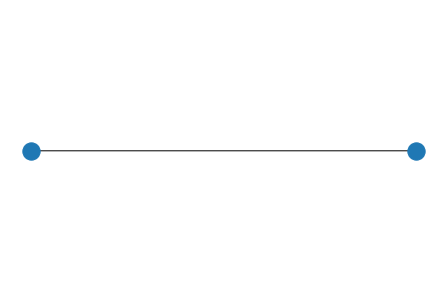

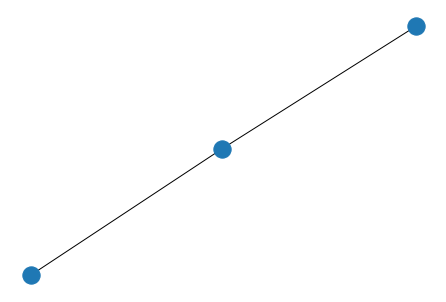

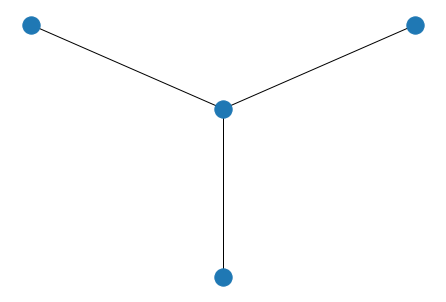

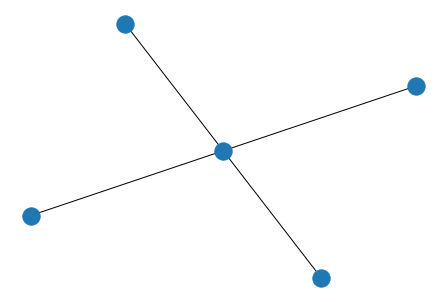

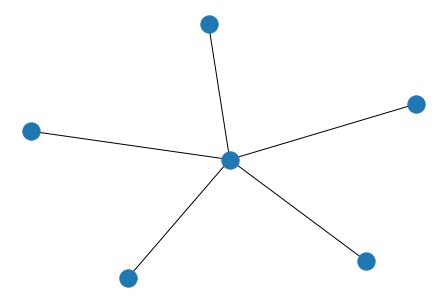

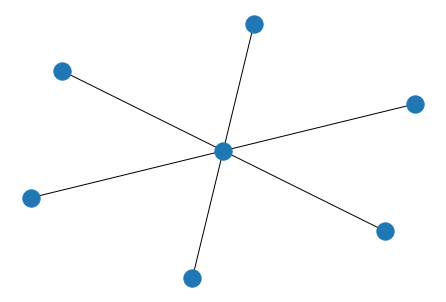

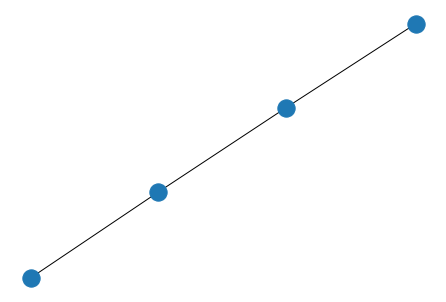

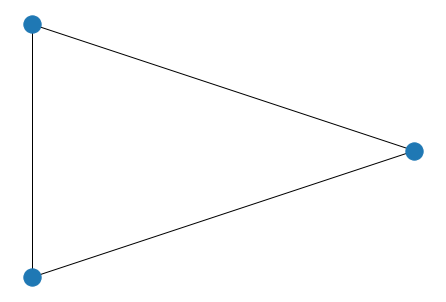

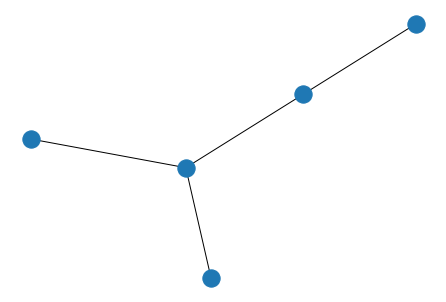

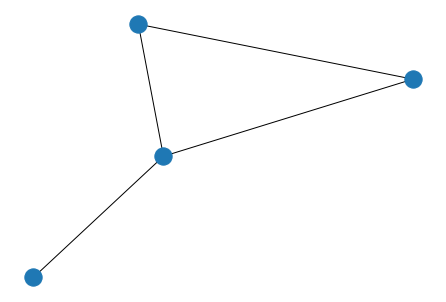

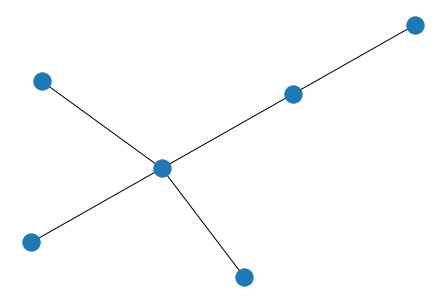

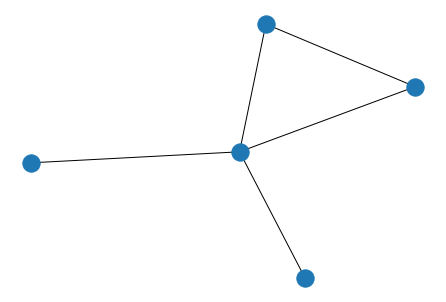

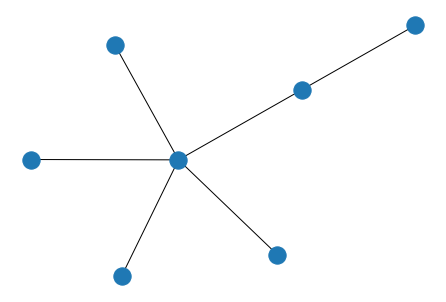

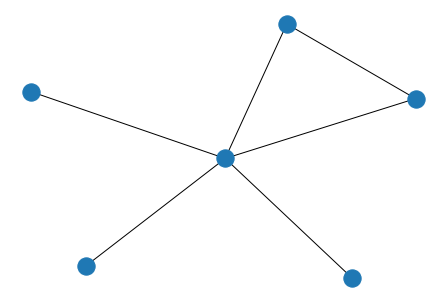

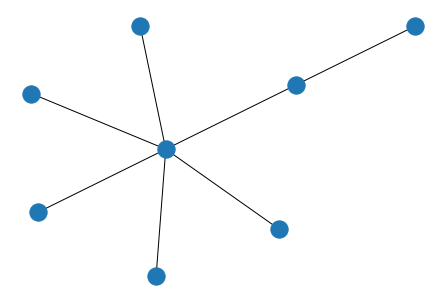

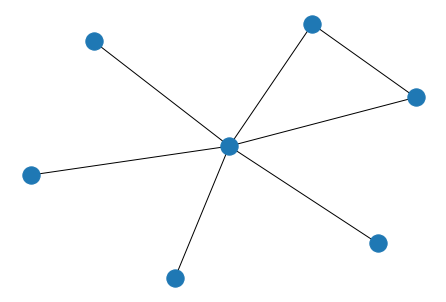

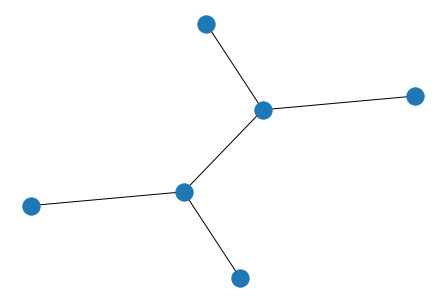

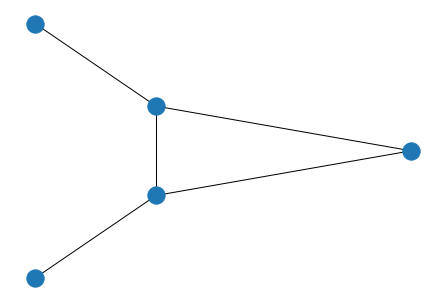

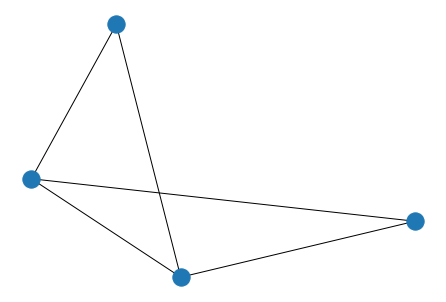

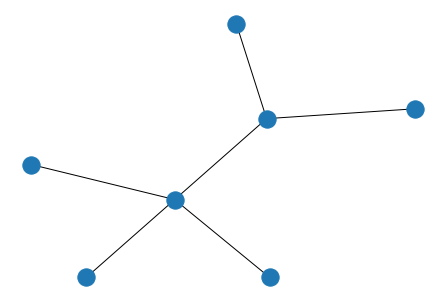

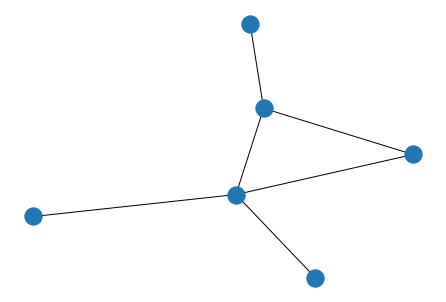

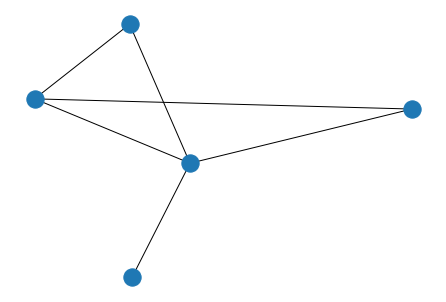

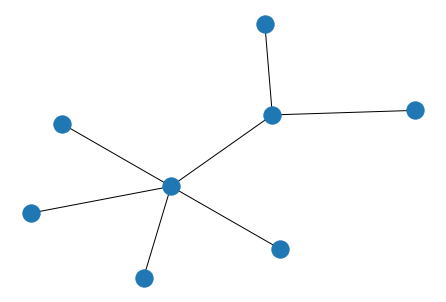

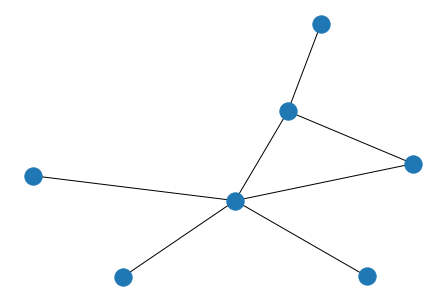

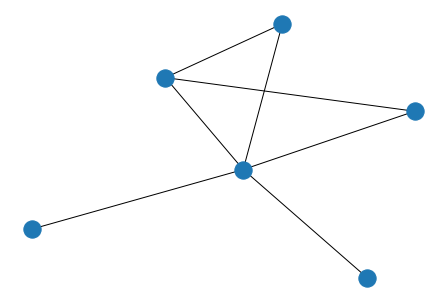

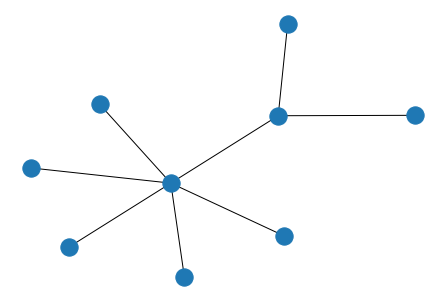

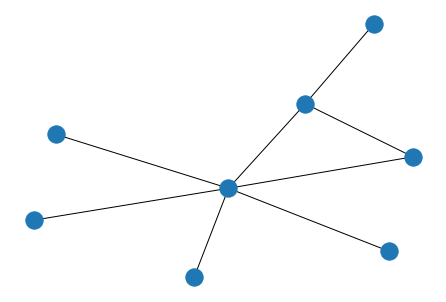

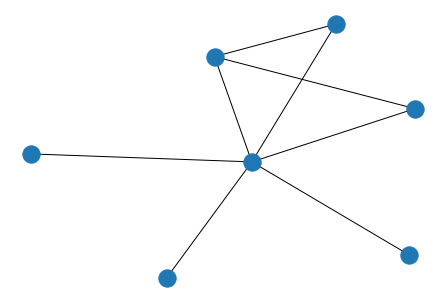

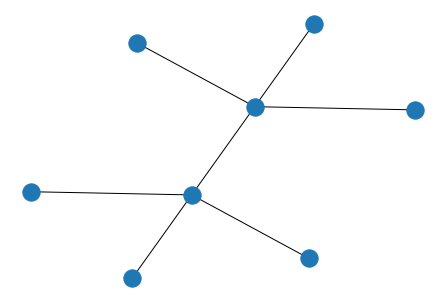

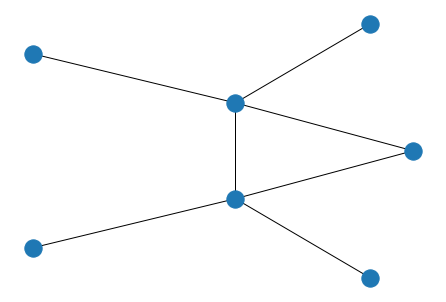

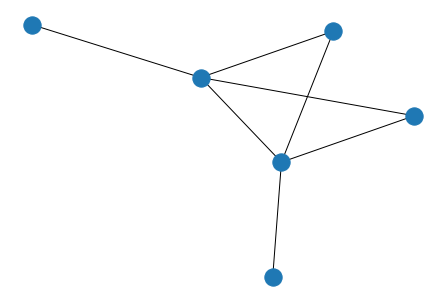

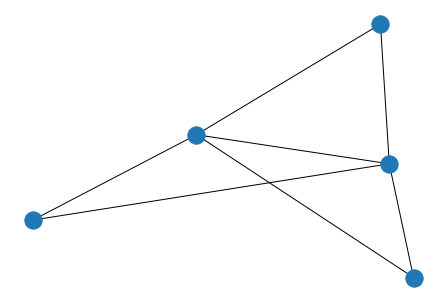

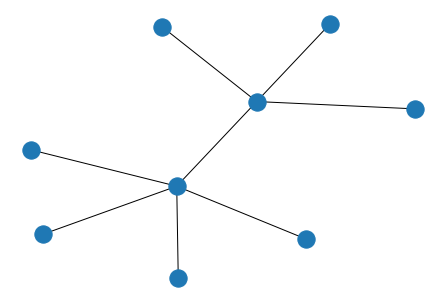

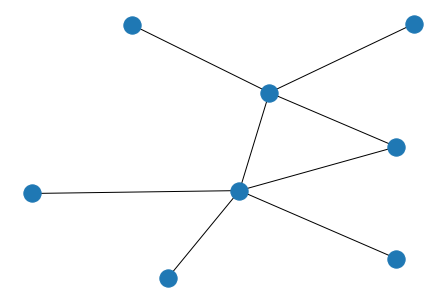

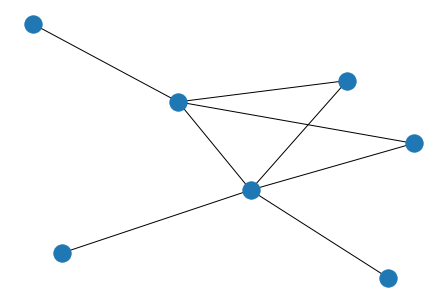

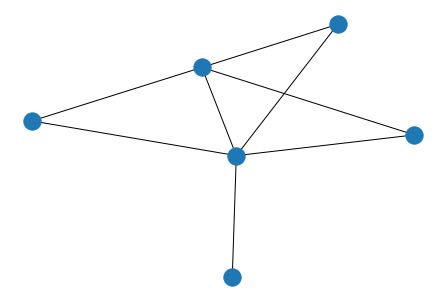

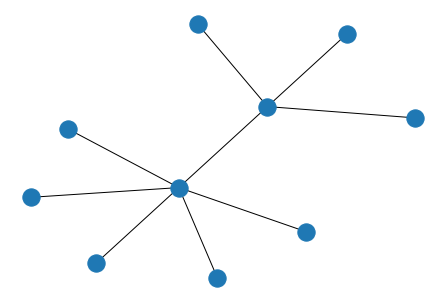

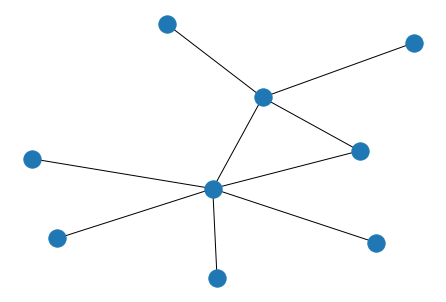

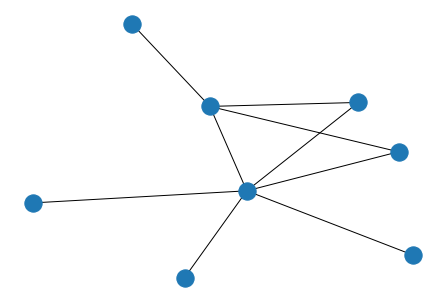

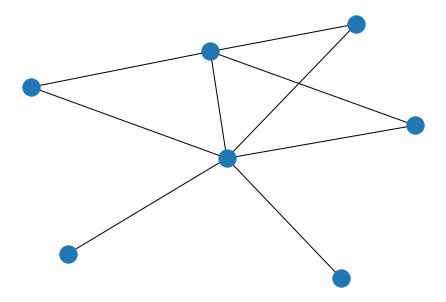

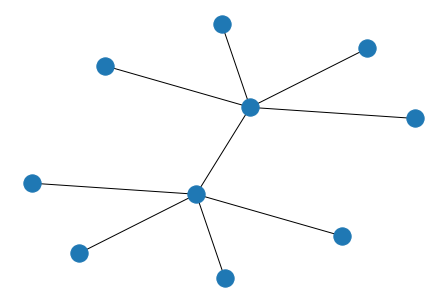

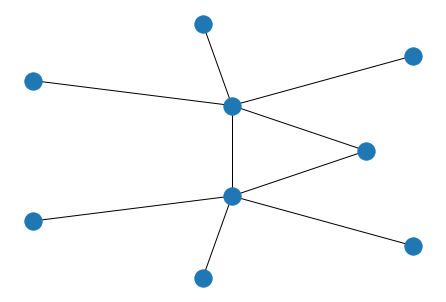

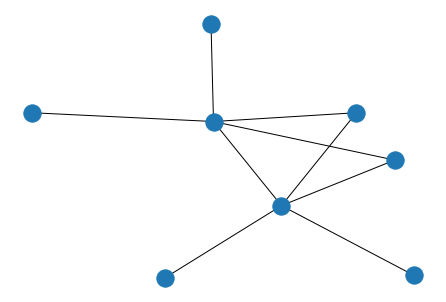

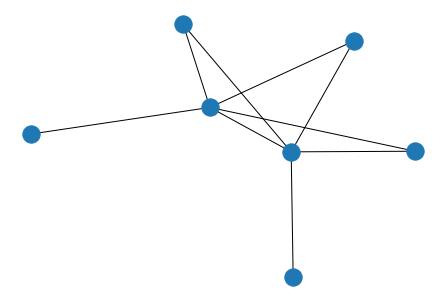

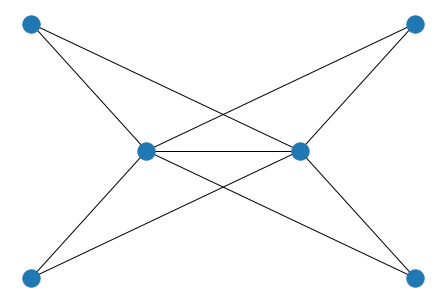

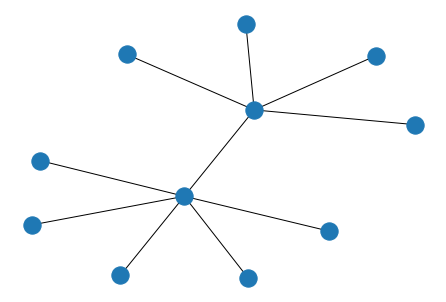

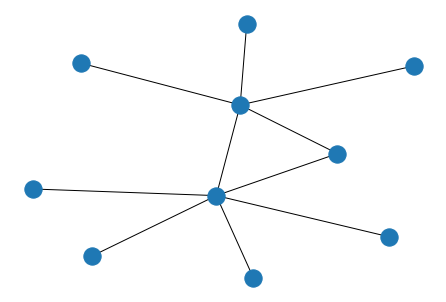

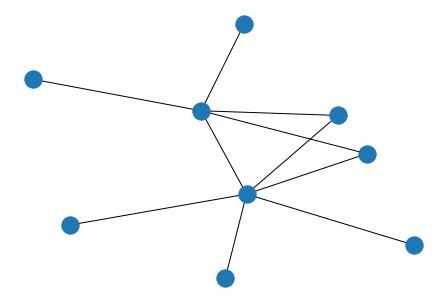

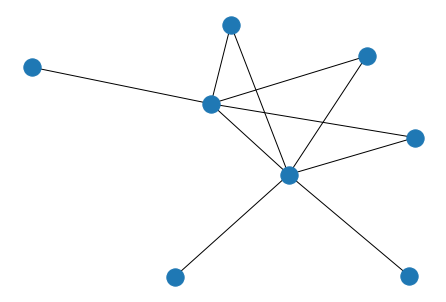

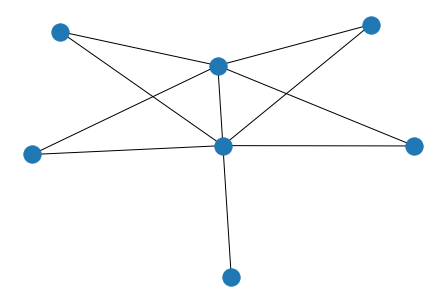

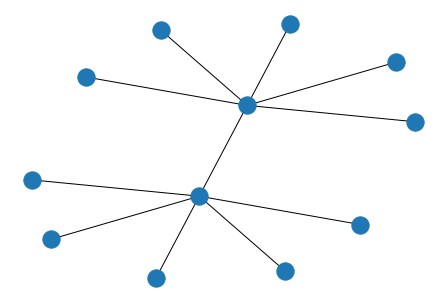

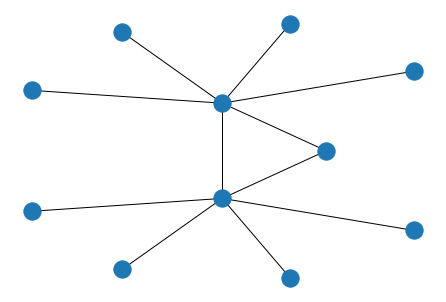

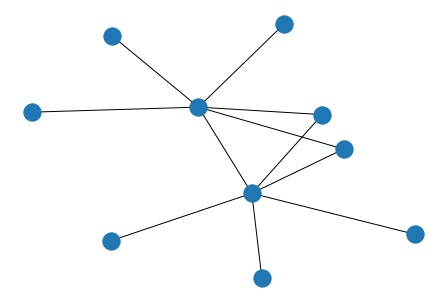

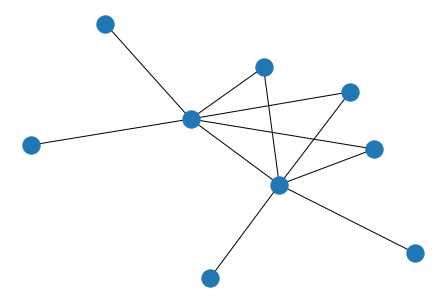

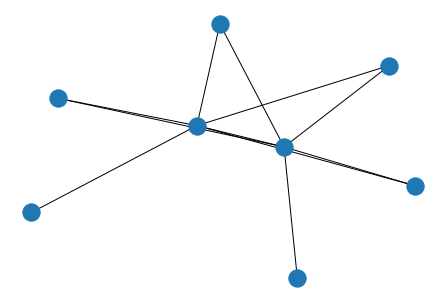

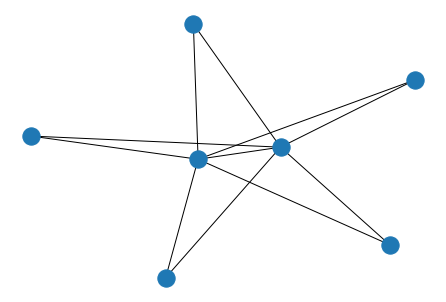

In [39]:
#generating all subgraphs first 
d_min = 1
d_max = 6
g_all = []
for i in range(d_min, d_max + 1):
    for j in range(i, d_max + 1):
        g_sub_ij = sub_all(i, j, draw=True)
        g_all += g_sub_ij

In [40]:
len(g_all)

56

In [41]:

def get_local_optima(subgraph,cutoff = 0.5, edge=(0,1), steps=50, multistarts =20):
    """
    Given a subgraph return those witin 10% of global
    """
    all_params = []
    all_energies = []
    for m in range(multistarts):
        
        p=1
        gamma = [np.random.rand() for i in range(p)]
        beta = [np.random.rand() for i in range(p)]
        loss_history, params_history = popt.qaoa_maxcut_torch(subgraph, gamma, beta,
                                                              ordering_algo='greedy',
                                                              Opt=torch.optim.RMSprop,
                                                              edge=edge,
                                                              opt_kwargs=dict(lr=0.002),
                                                              steps=steps,
                                                              pbar=False)
        energies_history = [(1-loss)/2 for loss in loss_history]
        
        all_params+=params_history
        all_energies+=energies_history
    
    #print(all_energies)
    best_index = np.argmax(all_energies)
    best_energy = float(all_energies[best_index])
    best_param = all_params[best_index]
    
    #storing data for local optima
    local_params= [best_param]
    local_energies = [best_energy]
    
    #add all local
    for i in range(len(all_energies)):
        energy = all_energies[i]
        params = all_params[i]
        
        if (abs(energy-best_energy)/best_energy)<cutoff:
            local_params.append(params)
            local_energies.append(energy)
    
        
    return local_params, local_energies

In [42]:
def fix_param(params):
    """
    Assuming gamma ranges from 0 to 1 and beta from 0 to 0.5 and both are preiodic
    """
    new_params = []
    for p in params:
        gamma = float(p[0])
        beta = float(p[1])
        gamma = gamma%1
        beta = beta%0.5
        new_params.append([gamma, beta])
    return new_params

In [43]:
import pandas as pd
from sklearn.cluster import KMeans

# Some Useful Code for finding max density of scatterplots

In [44]:
def max_density_center(x_, y_):
    """
    Returns the point of maximum density on scatterplot
    """
    pts_x = np.array(x_)
    pts_y = np.array(y_)


    RESOLUTION = 50
    LOCALITY = 2

    dx = max(pts_x) - min(pts_x)
    dy = max(pts_y) - min(pts_y)

    delta = min(dx, dy) / RESOLUTION
    nxx = int(dx / delta)
    ny = int(dy / delta)
    radius = (1 / LOCALITY) * min(dx, dy)

    grid_x = np.linspace(min(pts_x), max(pts_x), num=nxx)
    grid_y = np.linspace(min(pts_y), max(pts_y), num=ny)

    x, y = np.meshgrid(grid_x, grid_y)
    
    ######
    def gauss(x1, x2, y1, y2):
        """
        Apply a Gaussian kernel estimation (2-sigma) to distance between points.

        Effectively, this applies a Gaussian kernel with a fixed radius to one
        of the points and evaluates it at the value of the euclidean distance
        between the two points (x1, y1) and (x2, y2).
        The Gaussian is transformed to roughly (!) yield 1.0 for distance 0 and
        have the 2-sigma located at radius distance.
        """
        return (
            (1.0 / (2.0 * math.pi))
            * math.exp(
                -1 * (3.0 * math.sqrt((x1 - x2)**2 + (y1 - y2)**2) / radius))**2
            / 0.4)


    def _kde(x, y):
        """
        Estimate the kernel density at a given position.

        Simply sums up all the Gaussian kernel values towards all points
        (pts_x, pts_y) from position (x, y).
        """
        return sum([
            gauss(x, px, y, py)
            # math.sqrt((x - px)**2 + (y - py)**2)
            for px, py in zip(pts_x, pts_y)
        ])
    
    kde = np.vectorize(_kde)  # Let numpy care for applying our kde to a vector
    z = kde(x, y)
    
    yi, xi = np.where(z == np.amax(z))
    max_x = grid_x[xi][0]
    max_y = grid_y[yi][0]

    fig, ax = plt.subplots()
    ax.pcolormesh(x, y, z, cmap='inferno', vmin=np.min(z), vmax=np.max(z))
    fig.set_size_inches(4, 4)
    #fig.savefig('density.png', bbox_inches='tight')
    plt.xlabel("beta")
    plt.ylabel("gamma")
    plt.show()

    fig, ax = plt.subplots()
    ax.scatter(pts_x, pts_y, marker='+', color='blue')
    ax.scatter(max_x, max_y, marker='+', color='red', s=200)
    fig.set_size_inches(4, 4)
    print(f"{max_x:.4f}, {max_y:.4f}")
    #fig.savefig('marked.png', bbox_inches='tight')
    plt.show()
    
    return max_x, max_y

# Importing random graphs

In [45]:
g_data = []
with open('20NodeRandomData1.csv', 'r', newline = '') as s:
    spamreader = csv.reader(s, quotechar='|')
    for row in spamreader:
        new_row = [float(i) for i in row]
        g_data.append(new_row)

In [46]:
resi = []
with open('20NodeRandomGraph1.csv', 'r', newline = '') as g:
  spamreader = csv.reader(g, quotechar='|')
  for row in spamreader:
    resi.append(row)

#convert bunch of rows to matrices
n = int(len(resi)/20)
mat_list = []
for i in range(n):
  array = []
  for j in range(20):
    row = resi[i*20 +j]
    row = [float(k) for k in row]
    array.append(row)
  mat_list.append(array)

In [47]:
def mats_to_graphs(mat_list):
  """
  Given list of adjaceny matrix repr of graphs, converts to actual graphs
  """
  g_list = []
  iterr = 0
  for mat in mat_list:
    iterr+=1
    print(iterr)
    arr = np.array(mat)
    G = nx.convert_matrix.from_numpy_matrix(arr)
    g_list.append(G)
  return g_list

In [48]:
g_list = mats_to_graphs(mat_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


In [49]:
type(mat_list[0])

list

In [50]:
len(g_data)

55

In [51]:
len(g_list)

55

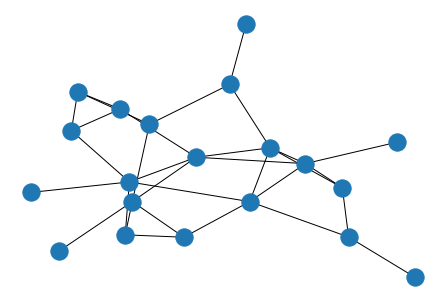

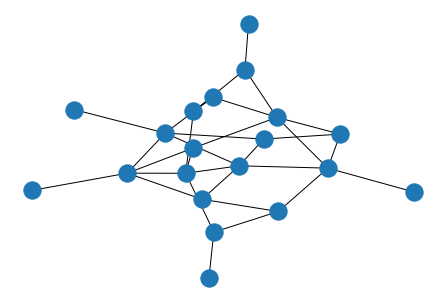

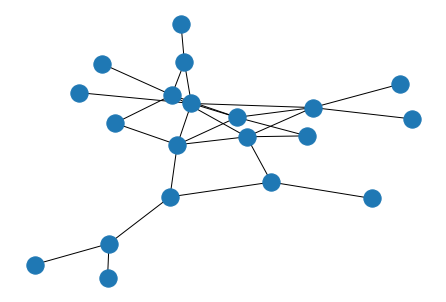

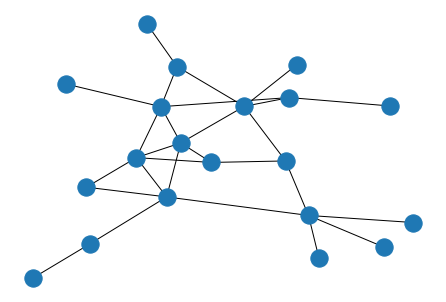

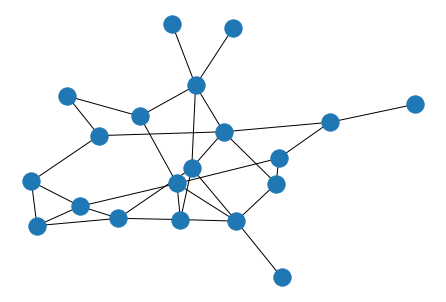

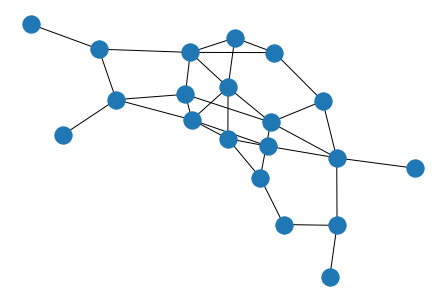

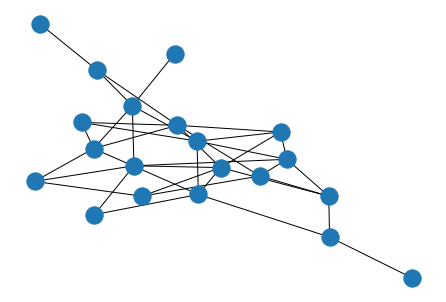

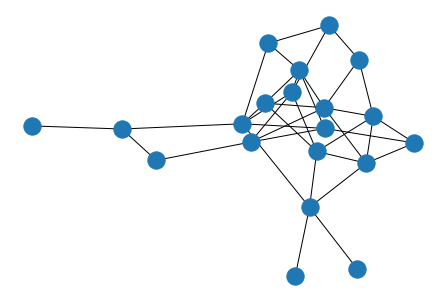

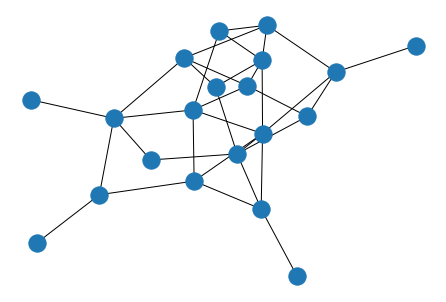

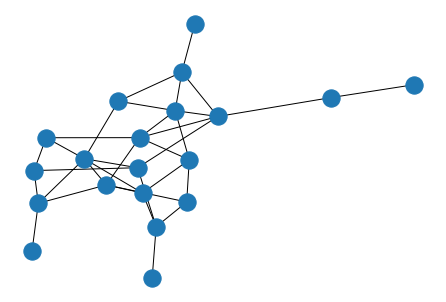

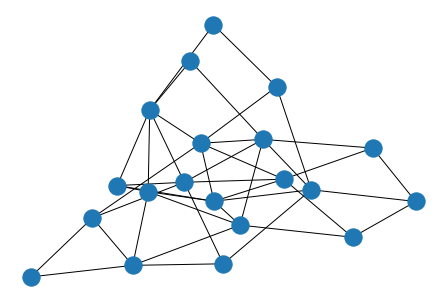

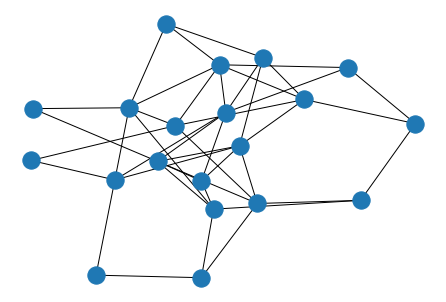

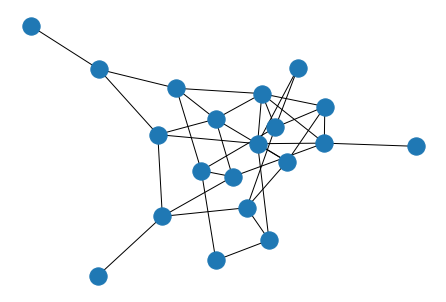

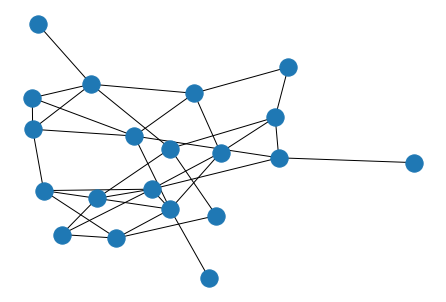

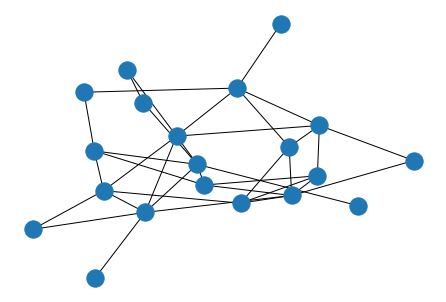

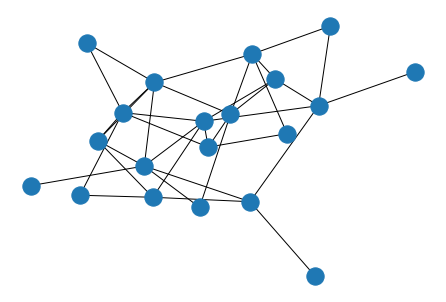

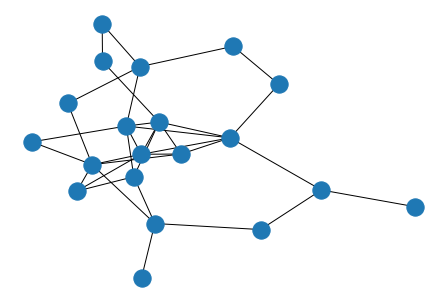

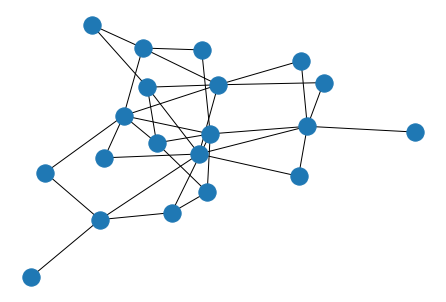

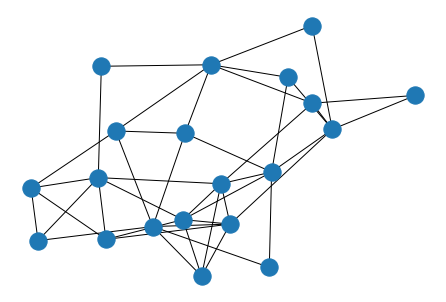

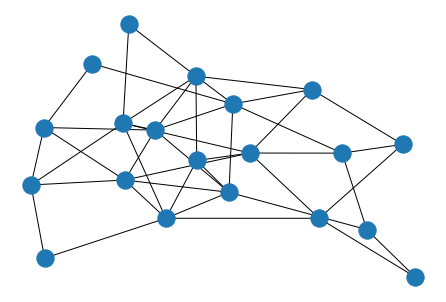

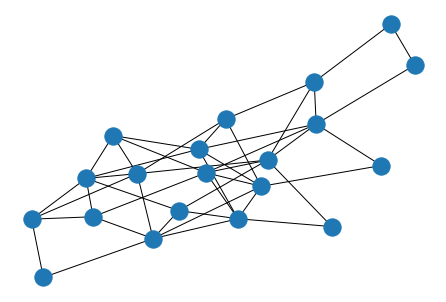

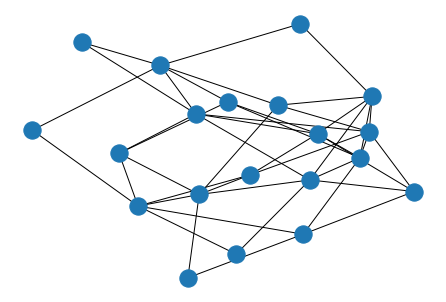

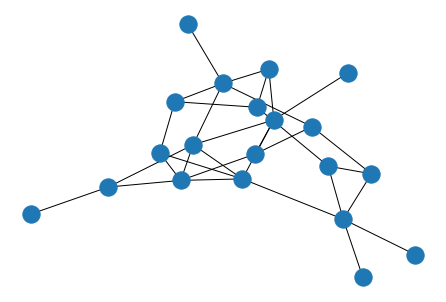

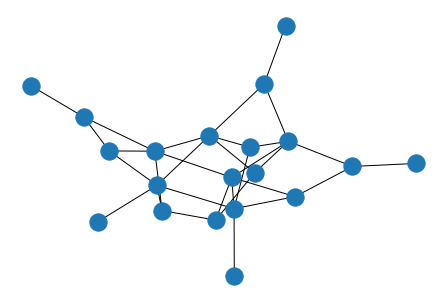

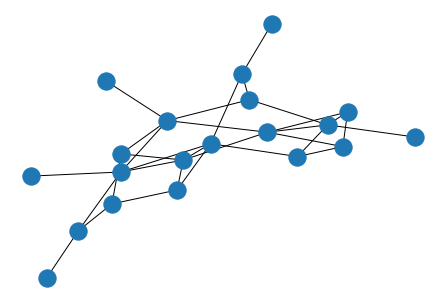

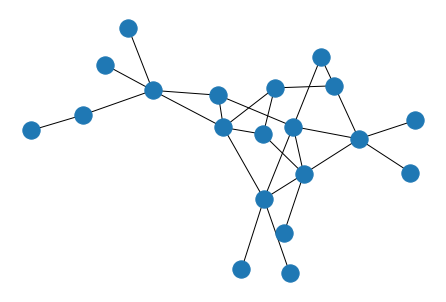

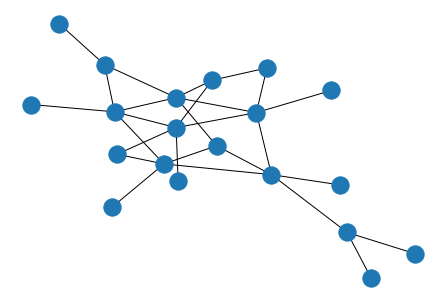

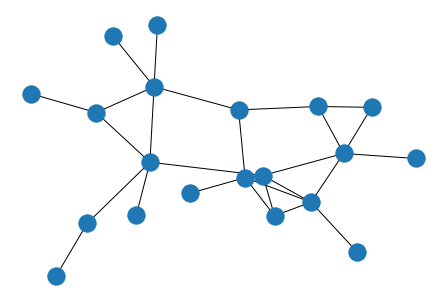

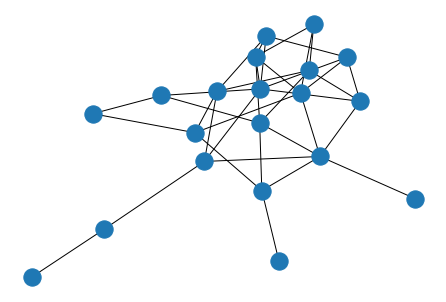

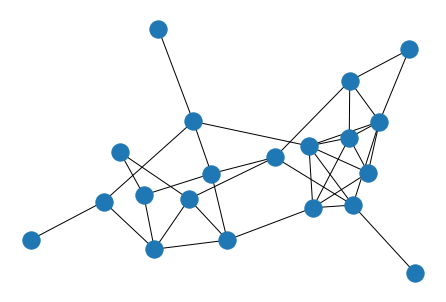

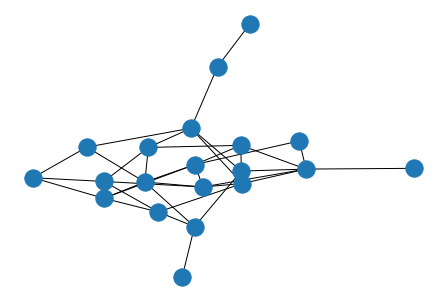

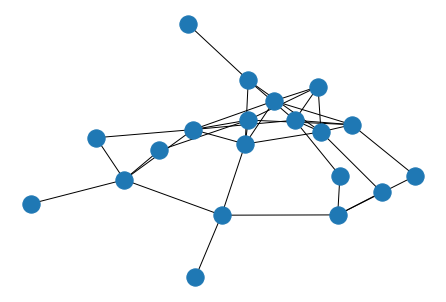

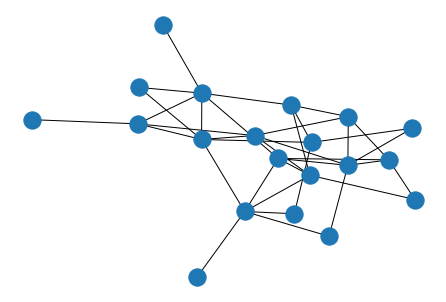

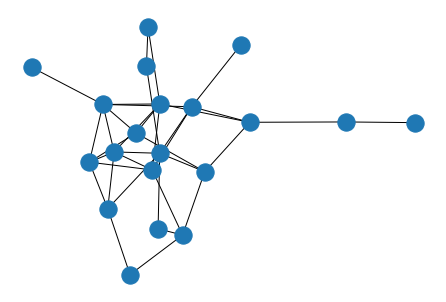

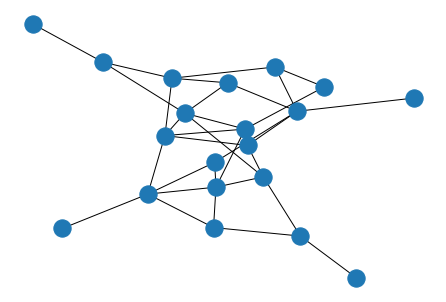

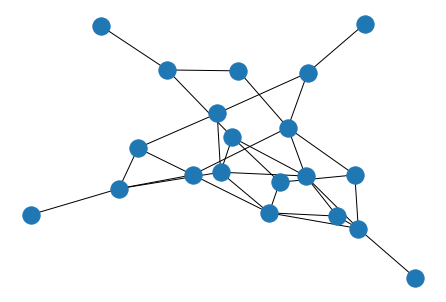

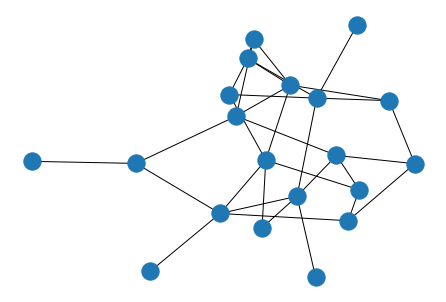

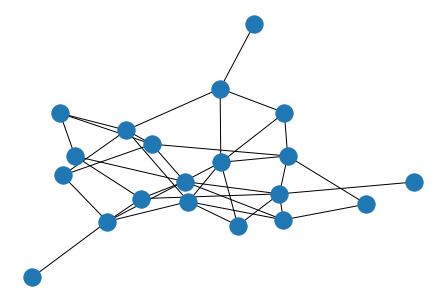

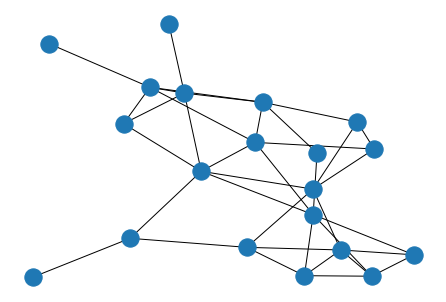

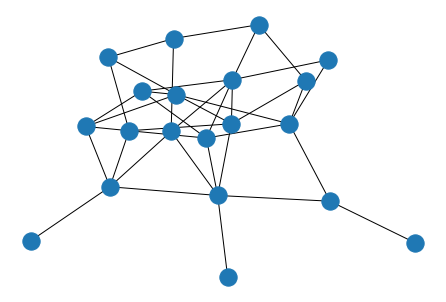

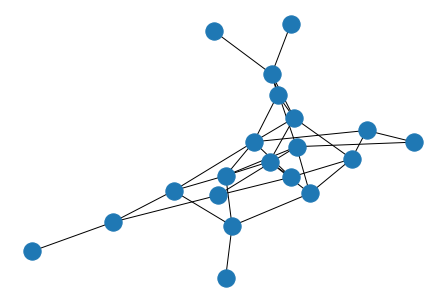

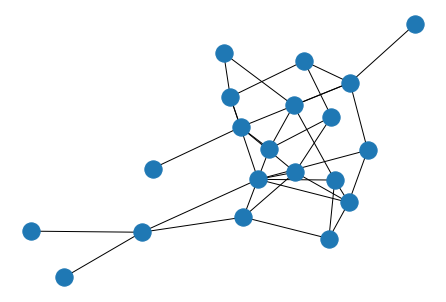

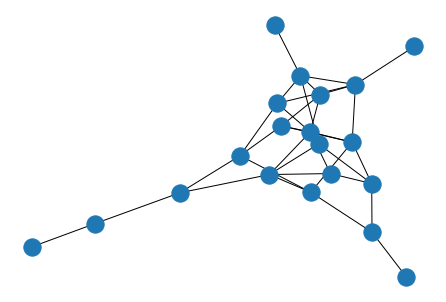

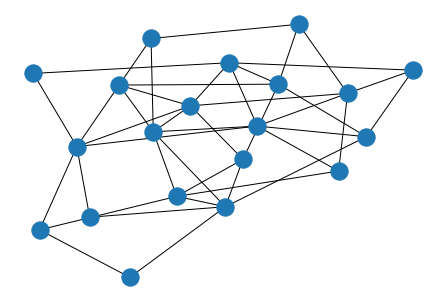

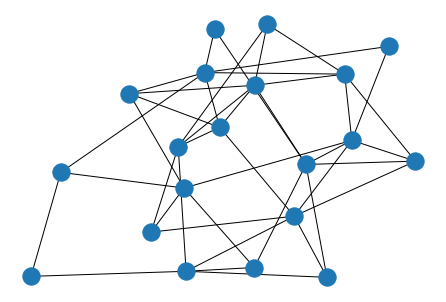

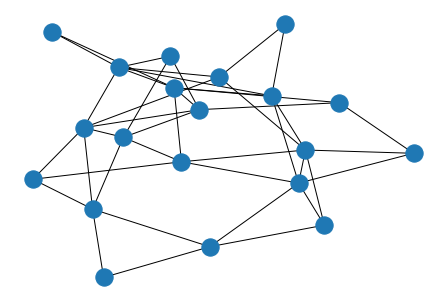

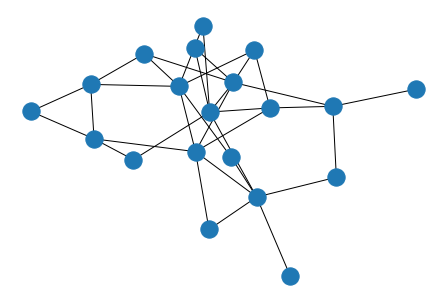

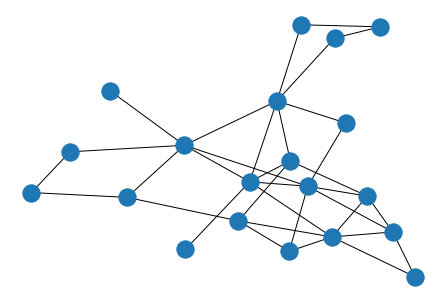

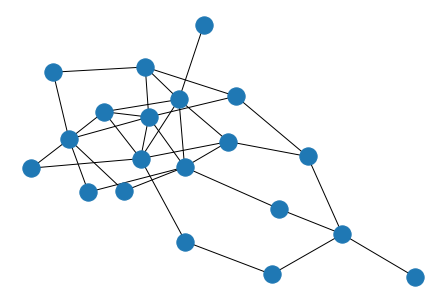

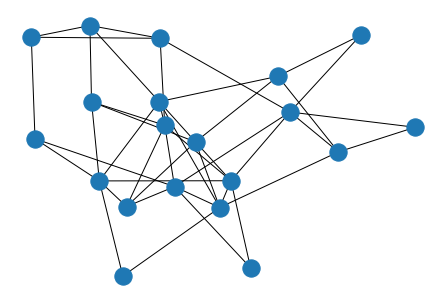

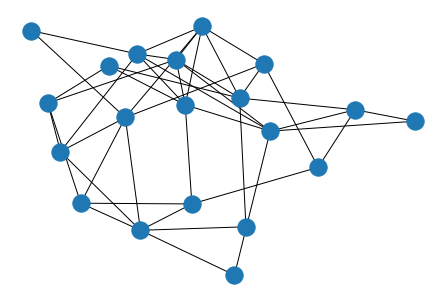

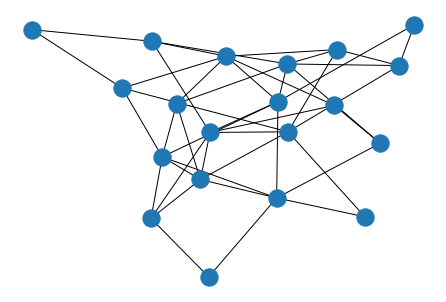

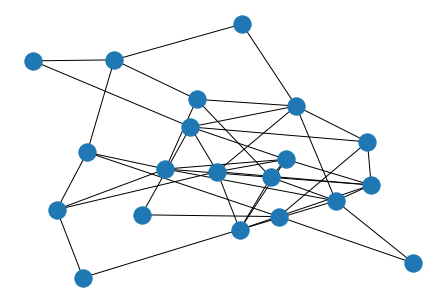

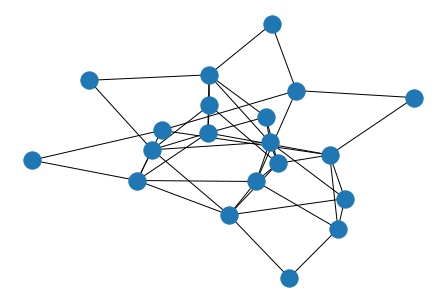

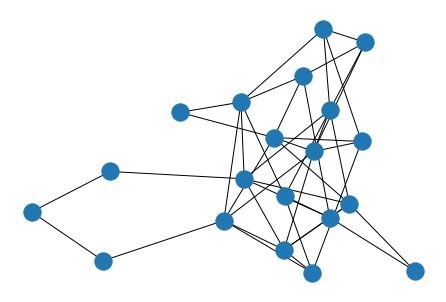

In [52]:
for i in g_list:
  nx.draw(i)
  plt.show()

# Doing the k means thing for all subgraphs
Assuming 4 clusters for all

Getting data from July 8 file

In [53]:
centers = [[0.37495592455418414, 0.24998826952466746],
 [0.12498338805473858, 0.750093454935025],
 [0.3748830576885996, 0.2558392745938469],
 [0.37500648414063614, 0.24369947422461882],
 [0.12497097102408494, 0.8333346553135789],
 [0.3749655557457262, 0.16662208117348565],
 [0.37514371204376185, 0.1709218004345881],
 [0.12508058297919872, 0.8289685894365171],
 [0.3748842254201723, 0.3482828063428106],
 [0.1249758842891087, 0.8480026642858295],
 [0.1249695525238818, 0.6517892500294866],
 [0.37499480579614997, 0.1514675239437882],
 [0.37484944704596396, 0.2501520863016663],
 [0.12499036904274005, 0.7498148563584615],
 [0.12500719195033633, 0.7434392859961115],
 [0.37549289479488257, 0.2565985885335173],
 [0.37499602318813197, 0.25007145113333384],
 [0.12496004103752198, 0.7500964579820935],
 [0.1250320990778965, 0.7424378705268003],
 [0.37506100756896543, 0.24244742608956385],
 [0.12492753722452037, 0.7498211776848521],
 [0.3749574168184436, 0.24988558062385907],
 [0.3749804888468453, 0.25735608269186633],
 [0.12503240805549096, 0.7422604429034092],
 [0.37504825268284686, 0.625081325938353],
 [0.3750213751833779, 0.12507878999087418],
 [0.12493809762339905, 0.3750188885941406],
 [0.1249907248909905, 0.8749860407485093],
 [0.40202406009516656, 0.0980204606486465],
 [0.40199643935453355, 0.597983655960402],
 [0.0979225076464193, 0.9019507429994962],
 [0.09813733616860629, 0.4021483033764449],
 [0.37496500827068124, 0.11080724975062078],
 [0.12501930064546127, 0.8893468792820457],
 [0.3785978184843606, 0.11072497594762937],
 [0.3748423572452293, 0.10882031301125061],
 [0.21115708070642844, 0.34424203478298415],
 [0.28888883716914415, 0.6557205646545686],
 [0.29333579570976726, 0.6563614477816317],
 [0.20610353093722772, 0.3437333302251225],
 [0.1250707657512749, 0.39766786068512416],
 [0.12500098462457565, 0.897706760666764],
 [0.37495299329326187, 0.10244831210614858],
 [0.3749633748772271, 0.6024101066257065],
 [0.10418917164354813, 0.4088261462614204],
 [0.10419787337280903, 0.9087326665516704],
 [0.3957114788353583, 0.0911994467117101],
 [0.3958378281693399, 0.5912724476270885],
 [0.37498791345552623, 0.09666891731409466],
 [0.12498177638661723, 0.9032499934980385],
 [0.1205027472782643, 0.903269056310045],
 [0.37496333536894433, 0.09978304922148762],
 [0.10638519803711569, 0.9104128603470045],
 [0.39357566018891066, 0.08965313186689783],
 [0.10604914119268977, 0.9067360188098668],
 [0.392989957955346, 0.0864765427228234],
 [0.37493223822355815, 0.09268862100148312],
 [0.37502784737640626, 0.5926301845491679],
 [0.1249598607326194, 0.9073258403575872],
 [0.12504391018919792, 0.40739343236733483],
 [0.1083049807763754, 0.9108834819861512],
 [0.3916962445911576, 0.08906401875516962],
 [0.391675138739653, 0.5889740749373469],
 [0.10829470492587007, 0.41096191545028277],
 [0.37508211450930523, 0.4020826286316501],
 [0.12492453220888008, 0.9020217603154749],
 [0.12492153355413002, 0.597919956034525],
 [0.3749881996036548, 0.09792880041941016],
 [0.10468317569277924, 0.5872913442844897],
 [0.3952611654110557, 0.41267571747800236],
 [0.10471905506731133, 0.912680983085546],
 [0.39535971761399513, 0.08736320871261549],
 [0.41015658204176547, 0.42180524332446795],
 [0.08994813936731721, 0.5782426116129835],
 [0.41003882287030924, 0.0781739992200246],
 [0.0898095106124856, 0.921722375279663],
 [0.12513394994472052, 0.9095972386391162],
 [0.3749485086722093, 0.09041110378642436],
 [0.123716578765988, 0.9094985825005598],
 [0.12806830661637453, 0.9093589697565351],
 [0.10690159871799246, 0.9169501110338071],
 [0.39311173371297015, 0.08302177927840754],
 [0.10762206788944141, 0.9192840203210927],
 [0.10588423656299702, 0.9142243281006812],
 [0.23176231906412356, 0.6099630236791062],
 [0.2680655891433883, 0.39001598166024765],
 [0.22617402133242837, 0.6103373231558965],
 [0.237295955796785, 0.609641561779795],
 [0.12499876464542051, 0.5850895917304602],
 [0.37500845874783495, 0.0851140413131729],
 [0.1249916358924617, 0.9148781093111022],
 [0.3749586469406443, 0.41490970054596504],
 [0.1085975168492133, 0.9200435722252298],
 [0.391336470559872, 0.42000779243536634],
 [0.39144435583024084, 0.08002042774610907],
 [0.10850918794461659, 0.5799724763769347],
 [0.09475189248773347, 0.5743943864528468],
 [0.40516814561090336, 0.074350395317132],
 [0.4052765594910912, 0.42563726757866294],
 [0.09471932099880528, 0.9255019692687323],
 [0.12497813080201176, 0.9188419199440867],
 [0.37496909812964135, 0.08115068513437207],
 [0.3777741396876231, 0.08118274256791186],
 [0.128752981312573, 0.9191280961968002],
 [0.39072154379553253, 0.08094506069189983],
 [0.10999052084542825, 0.922439623520106],
 [0.39001591433902727, 0.07758352669544383],
 [0.11378819896624626, 0.9227230064570906],
 [0.2988511640170099, 0.4034084509179464],
 [0.20111560657216354, 0.5965941465923994],
 [0.20730085143198565, 0.5955623698731264],
 [0.1951202585779387, 0.5977380131853037],
 [0.3749888417855992, 0.5833730688951548],
 [0.12502533539211336, 0.4166430269670953],
 [0.12507088017419277, 0.9166614188954714],
 [0.3749600386393447, 0.08331650558121195],
 [0.3912113144800151, 0.578048839390461],
 [0.108666905871551, 0.9219371912417222],
 [0.10868598738985455, 0.4219714650032043],
 [0.39131889816428855, 0.07802914030638852],
 [0.40509053788216154, 0.07257291988137515],
 [0.40494108717635374, 0.5725274752255464],
 [0.09503706789973362, 0.9274135307744377],
 [0.09508001904871166, 0.42741416884051814],
 [0.08449203004076186, 0.43423692017646986],
 [0.4157181419153224, 0.06593195336704177],
 [0.0843794267354048, 0.934192681898806],
 [0.4155998491004659, 0.565839480804304],
 [0.12500680330896274, 0.9215571240396201],
 [0.37508036308445303, 0.07844247558020007],
 [0.1214838192931243, 0.9216364970696825],
 [0.37252307578369465, 0.07851173071949585],
 [0.38988440669100877, 0.07444705266732643],
 [0.11005720930291385, 0.9255234365130383],
 [0.3902814381006288, 0.07763153968787762],
 [0.11392719257209044, 0.9255975203381643],
 [0.2661595866506305, 0.590497311327115],
 [0.23395233749062666, 0.40950116443809936],
 [0.25976464091515056, 0.590090682311934],
 [0.27261718666111984, 0.5908542529300408],
 [0.26143962011392063, 0.5974590804380941],
 [0.23846897601404043, 0.40252570381012936],
 [0.23328709845932635, 0.40231754344243287],
 [0.24398936174417796, 0.4027442341310936],
 [0.12502980559203866, 0.42524819801664926],
 [0.12502465427426626, 0.9252745579444064],
 [0.37499315617253215, 0.07474702775622072],
 [0.3750869379685636, 0.5747266389625045],
 [0.3888429886984958, 0.07176075126650266],
 [0.1111508650704402, 0.4282406981255151],
 [0.38885284343568627, 0.5717500100926631],
 [0.11127795441812002, 0.9282201779823711],
 [0.09866268435350964, 0.4316448416075768],
 [0.40127028563677447, 0.06832573304856665],
 [0.09871886212537903, 0.9316249780518469],
 [0.40124474872419746, 0.5684078172872229],
 [0.411798694553162, 0.5635450257114852],
 [0.08817906992078398, 0.9364858763835613],
 [0.4117399852474536, 0.06351966394908742],
 [0.08816929634995146, 0.4364422301239095],
 [0.3750334572790459, 0.4261845747250619],
 [0.1249473406347334, 0.9262089143333652],
 [0.12504083534767324, 0.5737801185315671],
 [0.3748944239756322, 0.07378479495839219],
 [0.3887809993984139, 0.4293269962931411],
 [0.11117654444823064, 0.9292844132072133],
 [0.38870075850050934, 0.07066566460495421],
 [0.11115042937932512, 0.5706577524014392],
 [0.4010892777875586, 0.43282713002488776],
 [0.09877789667023137, 0.5672508970261388],
 [0.4011384906504415, 0.06723858021211482],
 [0.09878917922541022, 0.9327331459228547],
 [0.08836035979648676, 0.9373622391235346],
 [0.4115236346824045, 0.0625258577927833],
 [0.08852162971952052, 0.5625413014922526],
 [0.4116646545886431, 0.43734141899589235],
 [0.419744631913732, 0.4426608632881746],
 [0.08024451630994378, 0.942643118980848],
 [0.4197480062025818, 0.057414150563610655],
 [0.0806293638026134, 0.5571331608490864],
 [0.12511834975642686, 0.9296725805314174],
 [0.3750549232672431, 0.07025214477139291],
 [0.37150412797927856, 0.07029998317360897],
 [0.12259582281112671, 0.9295652104275559],
 [0.11208553991617828, 0.9321585429517665],
 [0.38783389619437536, 0.06784727139758784],
 [0.11672115325927734, 0.9322233395650985],
 [0.39010104665192213, 0.06780848892465746],
 [0.40150749322139834, 0.06510886875065891],
 [0.10033315887717012, 0.9350092865374295],
 [0.3977872102647212, 0.06497271846275077],
 [0.399664679203436, 0.06505145895225534],
 [0.23991094180770206, 0.5810162680908366],
 [0.26009246564882704, 0.41898592377425686],
 [0.25518883019685745, 0.419154089476381],
 [0.2454079246442569, 0.580834844394734],
 [0.24178894089930025, 0.5892323833523391],
 [0.25813255757036213, 0.41079446808494213],
 [0.2633360064475335, 0.4106302626222093],
 [0.24674982974926632, 0.5890357395013173],
 [0.37512517957459957, 0.5669413565832465],
 [0.3749884661997082, 0.06693704275527246],
 [0.1250759252418177, 0.9330506322722876],
 [0.12512960898007344, 0.4330613892085453],
 [0.38708422170839507, 0.5649144329979207],
 [0.11289108651078264, 0.9350747350466371],
 [0.3871729047802539, 0.06492134721358278],
 [0.11293646221318639, 0.4350745046172934],
 [0.39830393100432215, 0.06261183532483827],
 [0.3983282040867164, 0.5626326920014109],
 [0.10172526911797153, 0.9373850088123892],
 [0.10177916298512749, 0.43744601239692904],
 [0.40836591700562247, 0.559391189273749],
 [0.4083758575990053, 0.05939532189069563],
 [0.09173939026928371, 0.44061655684057704],
 [0.09174924840529927, 0.9405502688481584],
 [0.08336800602561481, 0.944576180984563],
 [0.41683127224242345, 0.05551855489104274],
 [0.4166295022903247, 0.5554278554128752],
 [0.08335562559622509, 0.44450684504795746],
 [0.4233918708943686, 0.051468759992873925],
 [0.07657096349911463, 0.44855817564114914],
 [0.07667037434115936, 0.9486244239278087],
 [0.42330289025419965, 0.5513954181614932]]

In [54]:
len(centers)

224

# Decompose Graphs

In [55]:
import networkx as nx

In [56]:
def find_index(sub, subgraphs):
    """
    finds index of subgraph sub is isomorphic with
    """
    i = 0
    while i<len(subgraphs):
        if nx.is_isomorphic(sub, subgraphs[i]):
            return i
        i+=1
    print('error: could not find subgraph')
    return -1

In [57]:
def find_subgraphs(G):
  '''
  Input: A graph G
  Output: A dictionary containg subgraphs and their frequency in G
  '''
  edges_done = []
  subgraphs = {}

  vertices = G.nodes
  for v1 in vertices:
    ######print('----------------------------------------')
    ######print('Parent checking for vertex ' +str(v1) )
    #print(G)
    #print(v1)
    neighbors = nx.all_neighbors(G,v1)
    ######print(neighbors)
    #iterate over edges
    for v2 in neighbors:
      ######print('Childchecking for vertex ' +str(v2) )
      ##if already there
      if (v1,v2) in edges_done:
        #######print('Already looked at')
        continue
      ##add if not there
      else:
        ######print('Not looked at')
        edges_done.append((v1,v2))
        edges_done.append((v2,v1))
      
      neighbors1 = nx.all_neighbors(G,v1)
      neighbors2 = nx.all_neighbors(G, v2)

      subg_edge_set = []
      for v in neighbors1:
        #######print(v)
        edge = (v1, v)
        subg_edge_set.append(edge)

      for v in neighbors2:
        ######print(v)
        if v is not v1:
          edge = (v2, v)
          subg_edge_set.append(edge)

      ##creating the subgraph
      H = G.edge_subgraph(subg_edge_set)

      ##check if isomorphic with any other subgraphs
      iso = False
      subgraphs_arr = subgraphs.keys()
      for subgraph in subgraphs_arr:
        if nx.is_isomorphic(H, subgraph):
          #######print('is isomorphic')
          subgraphs[subgraph] +=1
          iso = True
          break
      if iso == False:
        #######print('---------------Adding a subgraph--------------------')
        subgraphs[H] = 1
        ######print(subgraphs)
  return subgraphs

In [58]:
def approx_ratio(graph,graph_index, gamma, beta, results = g_data):
    """
    Returns approx ratio for given gamma, beta
    """
    en = QAOA_energy(graph, gamma = [gamma], beta = [beta])
    max_en = results[graph_index][2]
    return en/max_en

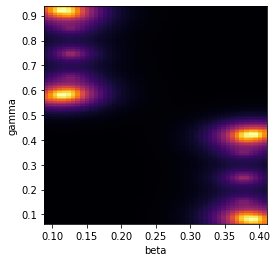

0.3853, 0.4216


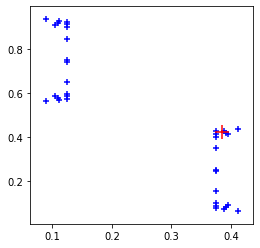

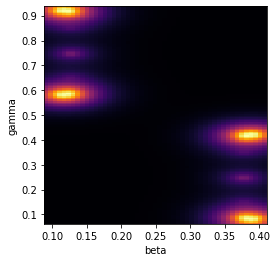

0.3787, 0.4151


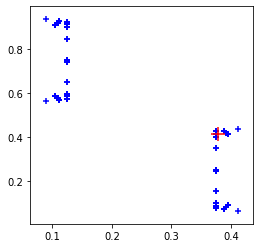


[0.9974816]
[0.99946983]


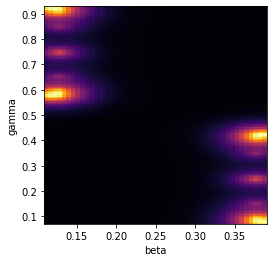

0.3799, 0.4198


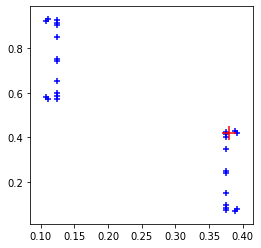

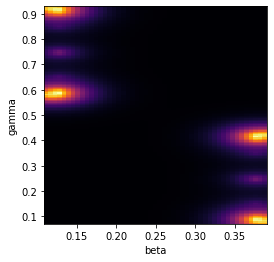

0.3741, 0.4141


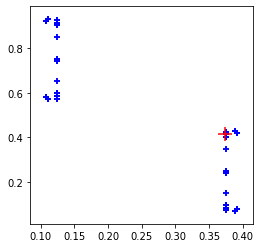


[0.99768754]
[0.99915591]


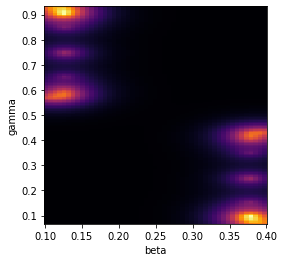

0.3765, 0.0977


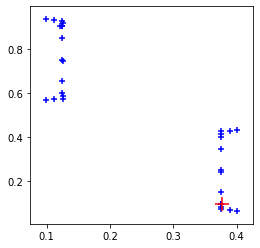

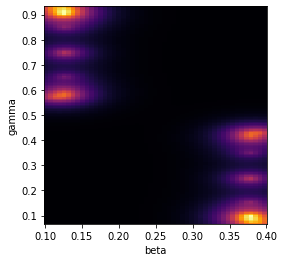

0.1235, 0.9084


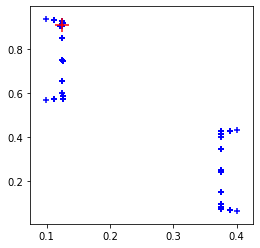


[0.99963996]
[0.99983356]


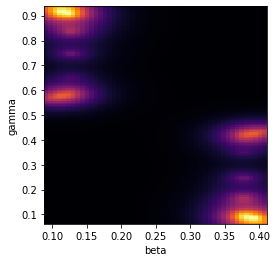

0.1148, 0.9112


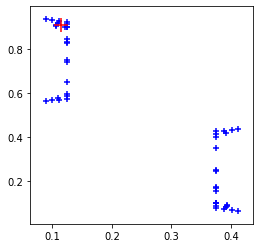

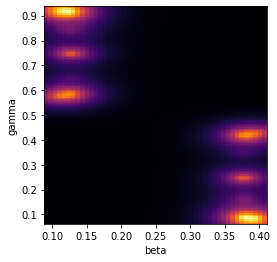

0.3787, 0.0821


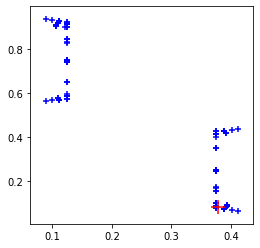


[0.99917132]
[0.99676531]


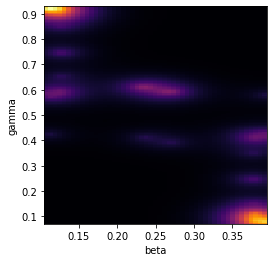

0.1106, 0.9234


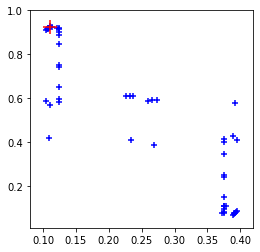

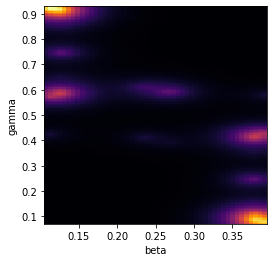

0.1106, 0.9234


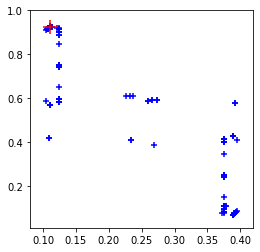


[0.9960575]
[0.9960575]


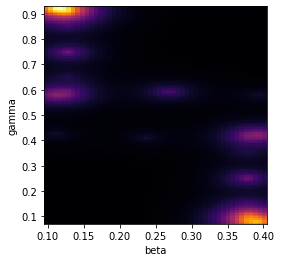

0.1137, 0.9167


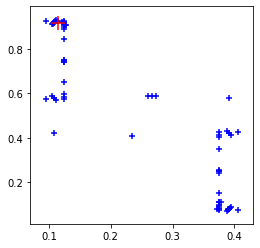

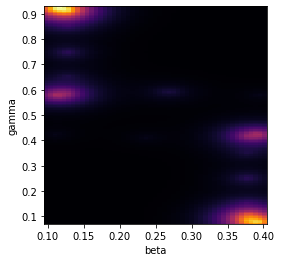

0.1137, 0.9230


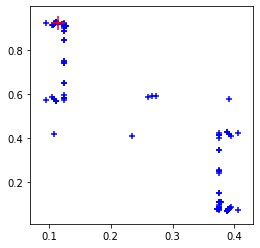


[0.9994596]
[0.99690723]


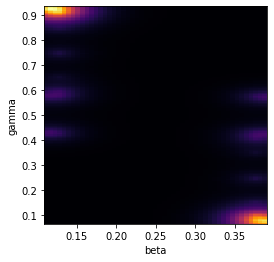

0.1143, 0.9236


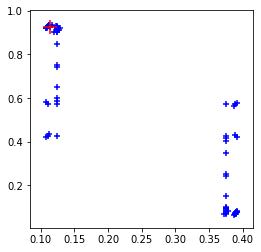

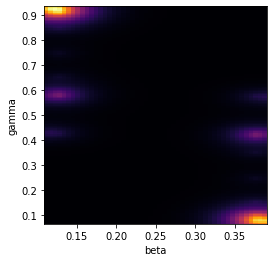

0.1201, 0.9236


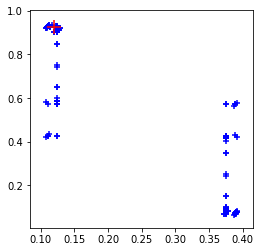


[0.99843005]
[0.99914453]


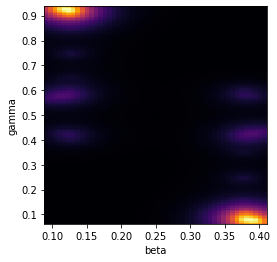

0.3853, 0.0756


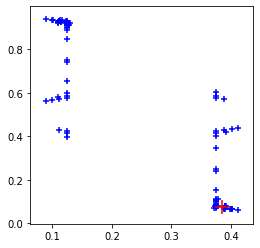

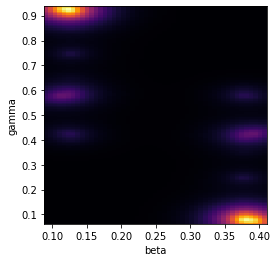

0.1214, 0.9243


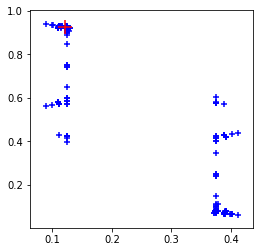


[0.99868362]
[0.99880703]


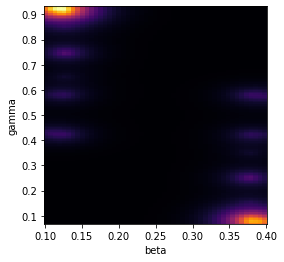

0.1172, 0.9200


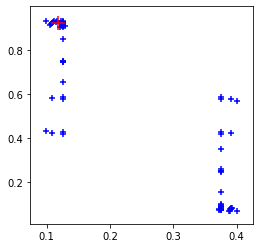

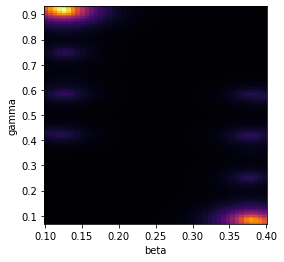

0.1234, 0.9138


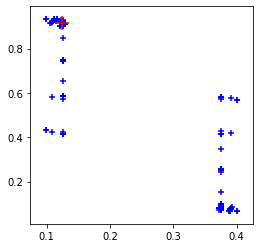


[0.99907449]
[0.99972186]


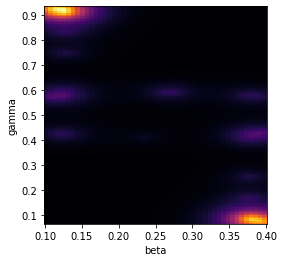

0.1235, 0.9166


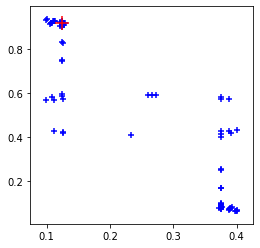

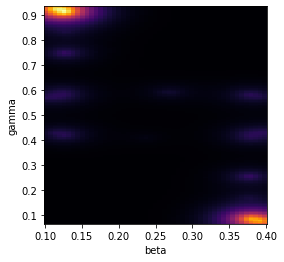

0.1235, 0.9166


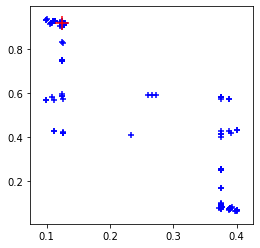


[0.99922878]
[0.99922878]


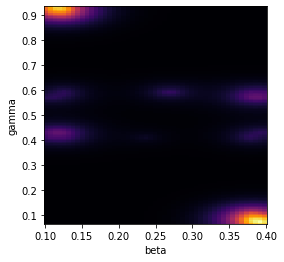

0.3891, 0.0710


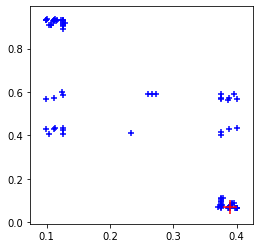

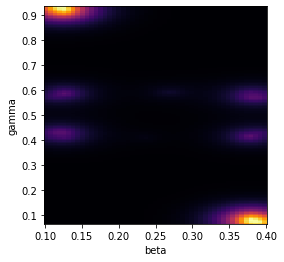

0.3768, 0.0772


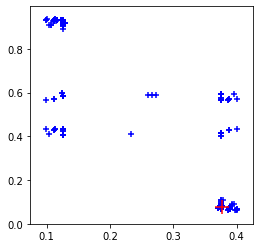


[0.99763169]
[0.99949337]


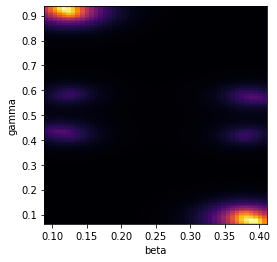

0.3854, 0.0757


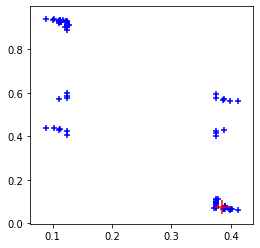

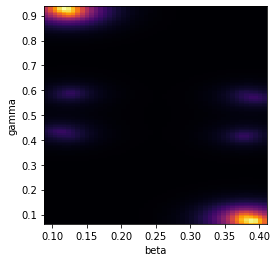

0.1146, 0.9243


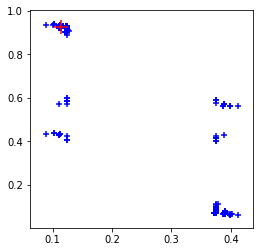


[0.99978191]
[0.99977989]


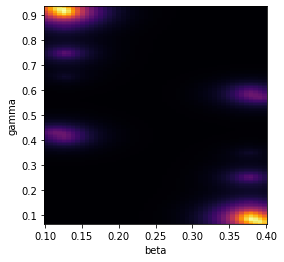

0.1234, 0.9167


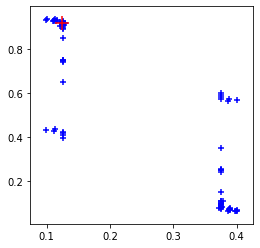

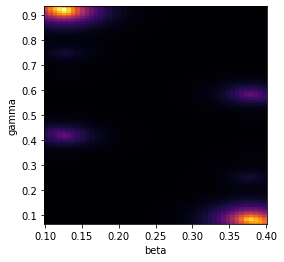

0.1234, 0.9167


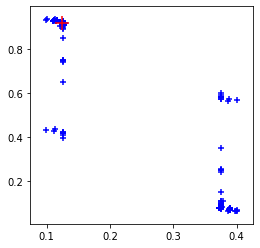


[0.99986774]
[0.99986774]


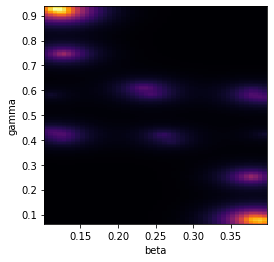

0.1138, 0.9254


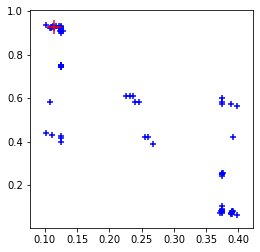

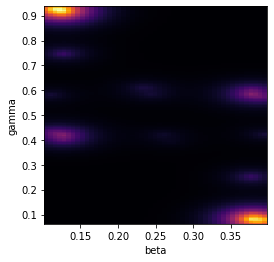

0.1199, 0.9194


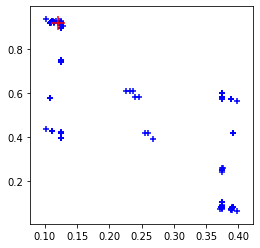


[0.99770527]
[0.99981846]


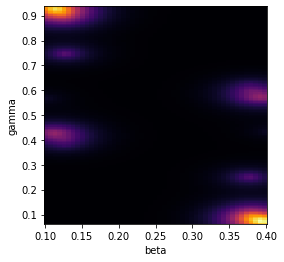

0.3891, 0.0748


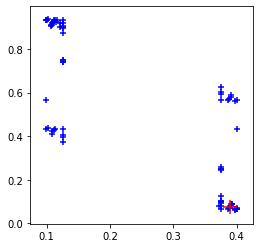

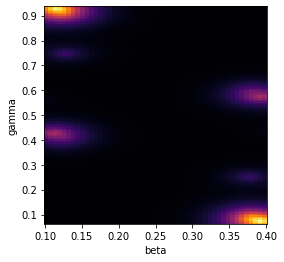

0.3891, 0.0748


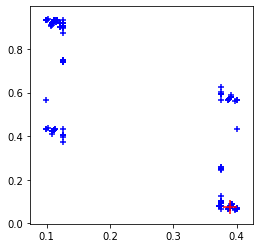


[0.99870312]
[0.99870312]


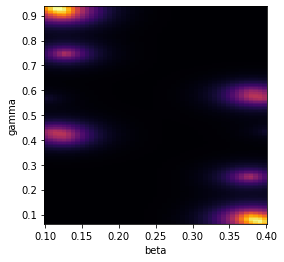

0.1172, 0.9252


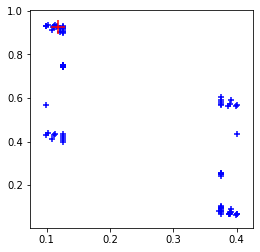

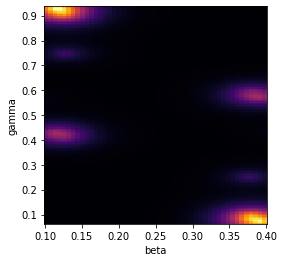

0.1172, 0.9252


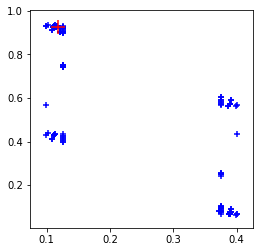


[0.99869708]
[0.99869708]


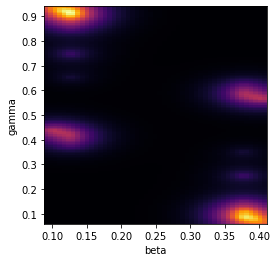

0.1212, 0.9144


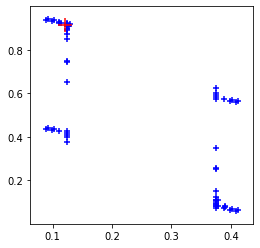

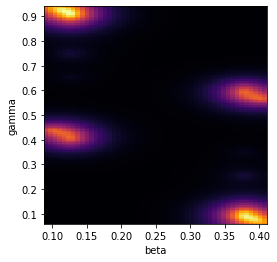

0.1212, 0.9144


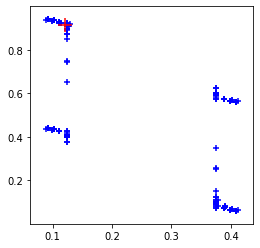


[0.99918674]
[0.99918674]


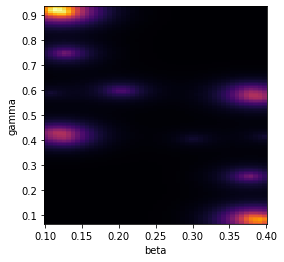

0.1110, 0.9167


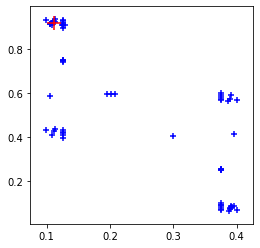

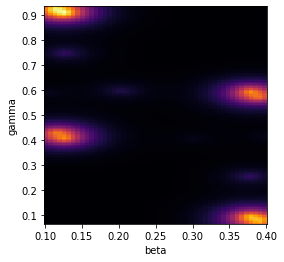

0.1234, 0.9106


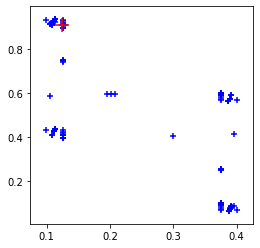


[0.99913178]
[0.99863735]


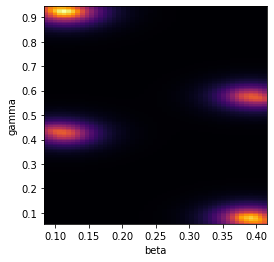

0.1106, 0.9244


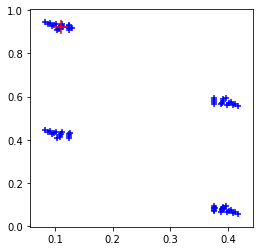

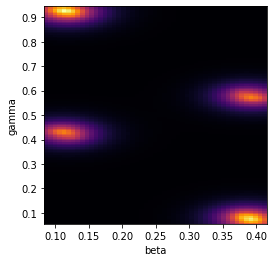

0.1106, 0.9244


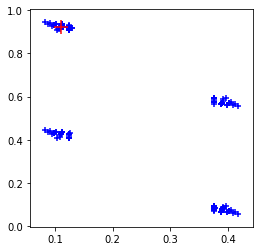


[0.99995627]
[0.99995627]


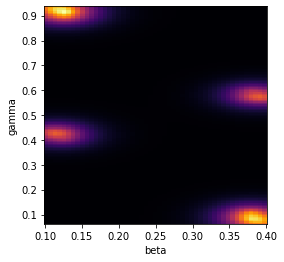

0.1234, 0.9129


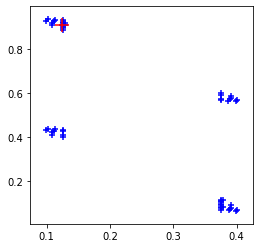

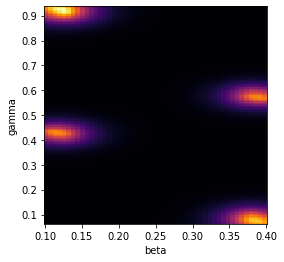

0.1234, 0.9252


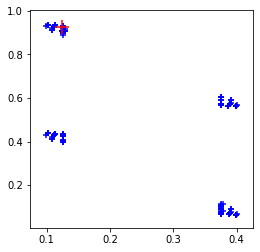


[0.99579286]
[0.99898385]


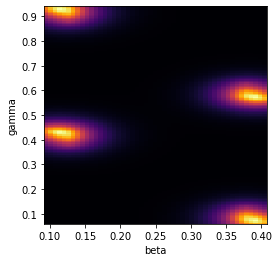

0.1111, 0.9278


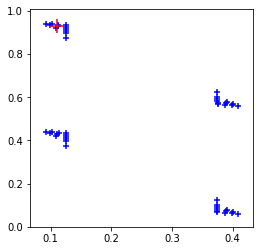

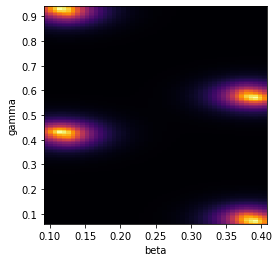

0.1111, 0.9278


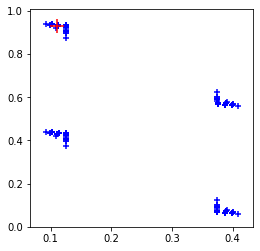


[0.99938288]
[0.99938288]


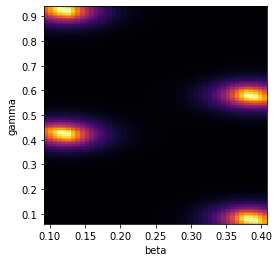

0.1176, 0.9278


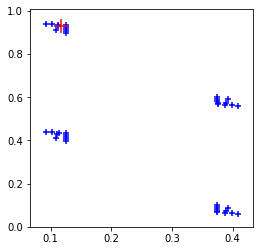

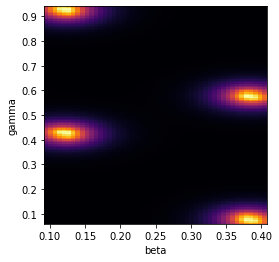

0.3761, 0.5766


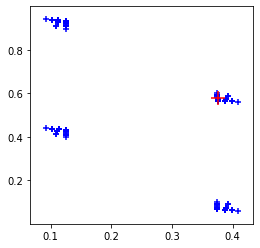


[0.99969883]
[0.99929238]


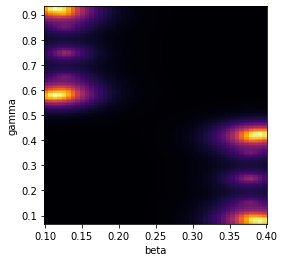

0.3888, 0.4208


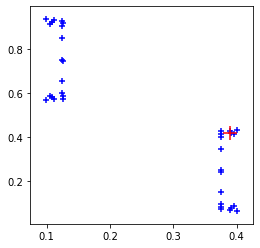

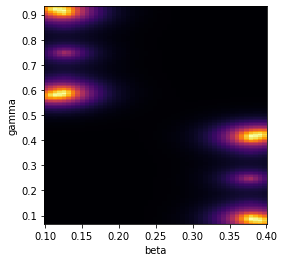

0.3765, 0.4147


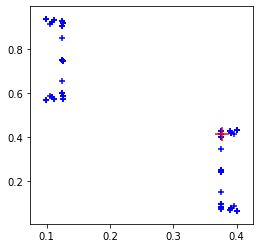


[0.99645728]
[0.9990086]


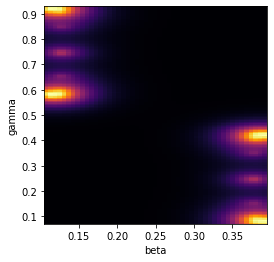

0.3894, 0.4176


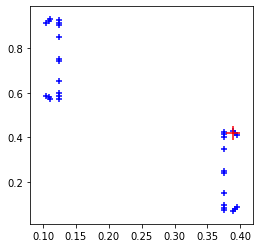

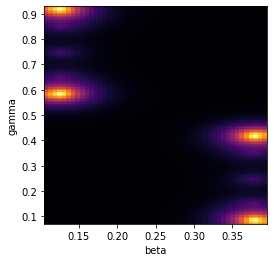

0.1225, 0.9175


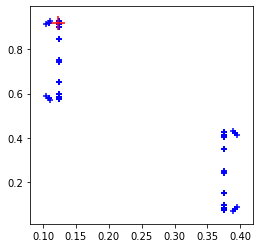


[0.99627343]
[0.99884607]


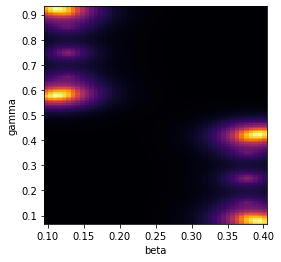

0.1074, 0.9202


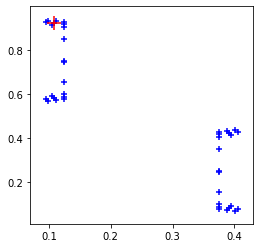

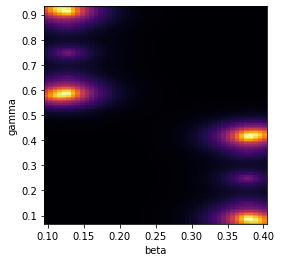

0.3736, 0.0861


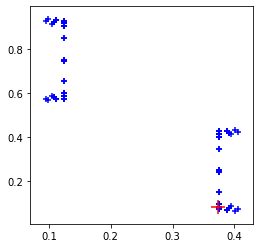


[0.9949142]
[0.99870816]


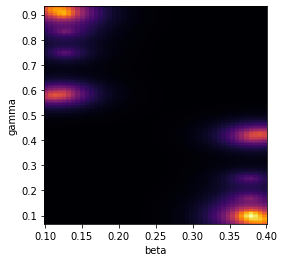

0.3765, 0.0977


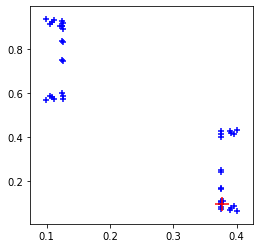

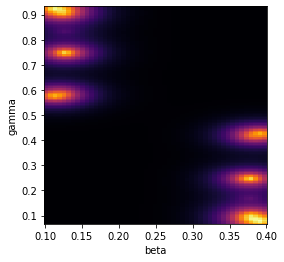

0.3888, 0.0794


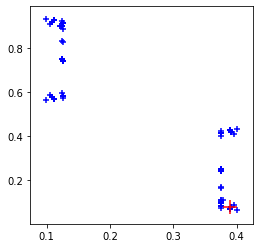


[0.99904116]
[0.99409106]


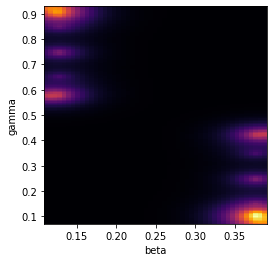

0.3741, 0.0993


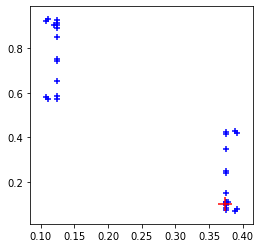

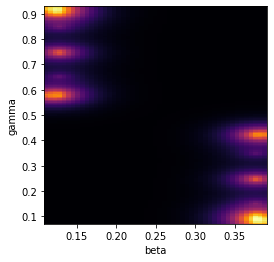

0.3741, 0.0878


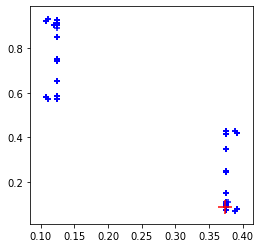


[0.99867289]
[0.99894189]


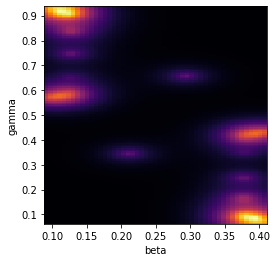

0.3919, 0.0821


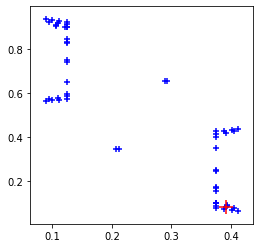

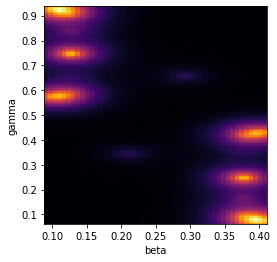

0.3919, 0.0756


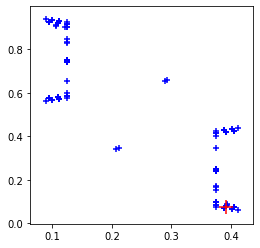


[0.99712116]
[0.99298723]


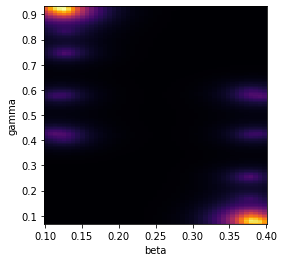

0.1234, 0.9200


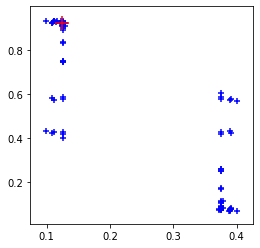

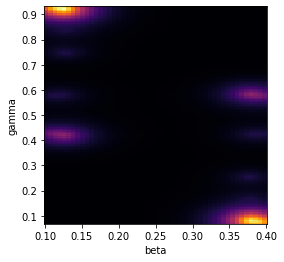

0.1234, 0.9200


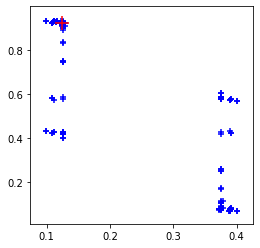


[0.99941283]
[0.99941283]


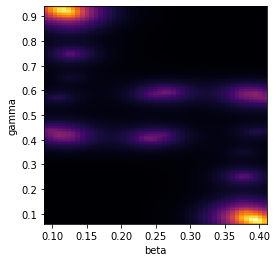

0.3920, 0.0724


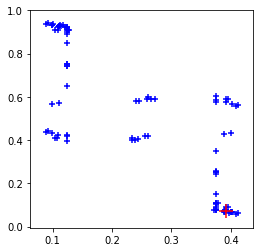

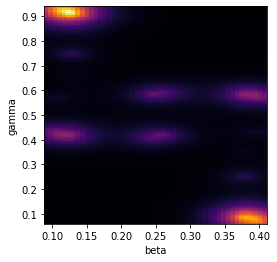

0.1212, 0.9144


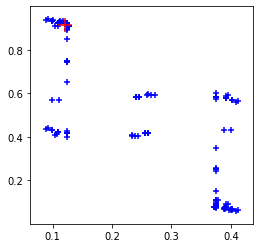


[0.99702933]
[0.99780112]


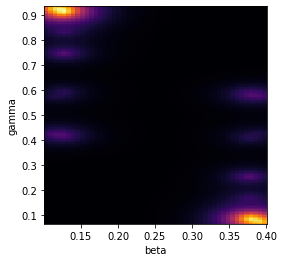

0.1249, 0.9168


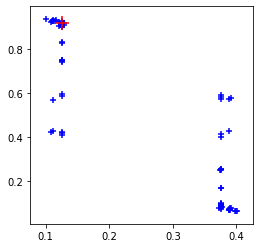

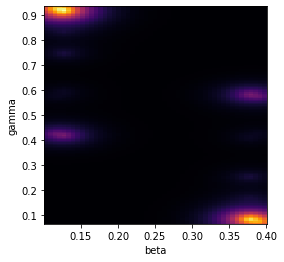

0.1249, 0.9168


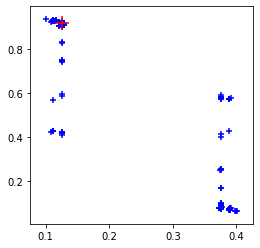


[0.99963611]
[0.99963611]


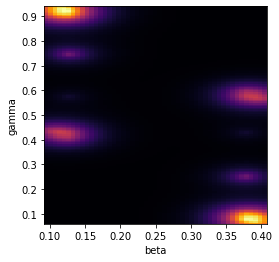

0.1176, 0.9214


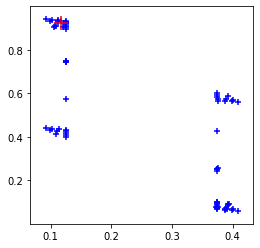

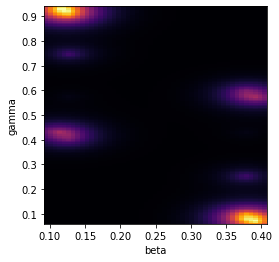

0.1176, 0.9278


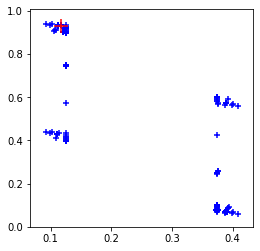


[0.99970102]
[0.99721917]


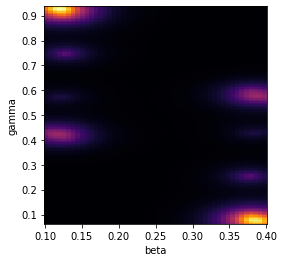

0.1172, 0.9252


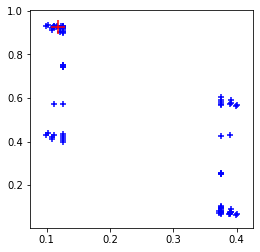

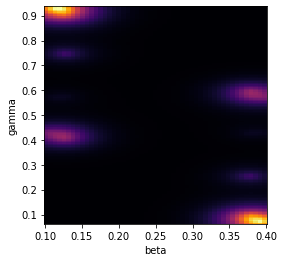

0.1172, 0.9252


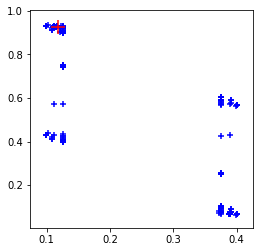


[0.99879387]
[0.99879387]


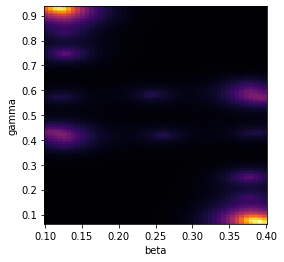

0.3891, 0.0687


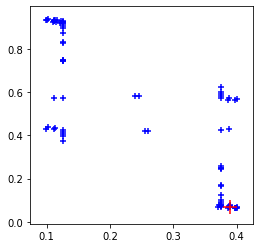

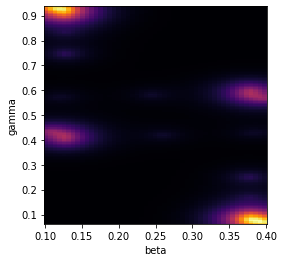

0.3891, 0.0748


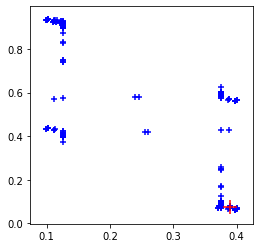


[0.99378834]
[0.99767635]


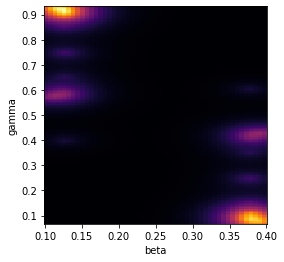

0.1235, 0.9144


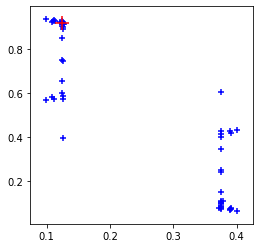

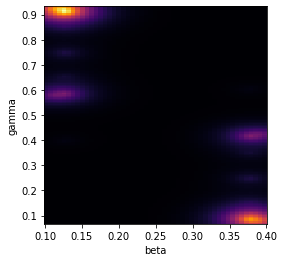

0.1235, 0.9144


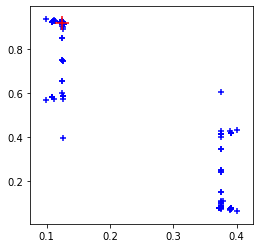


[0.99961702]
[0.99961702]


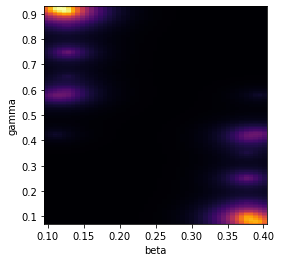

0.1137, 0.9167


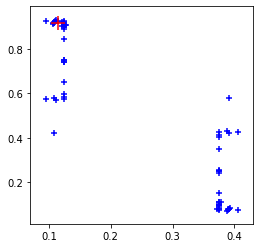

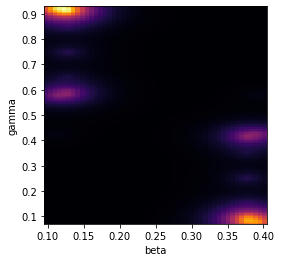

0.1201, 0.9167


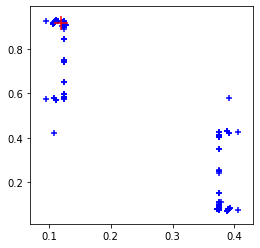


[0.99879785]
[0.99938633]


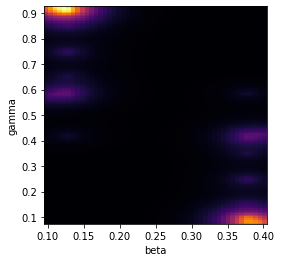

0.1201, 0.9137


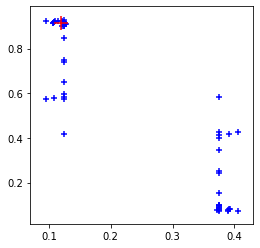

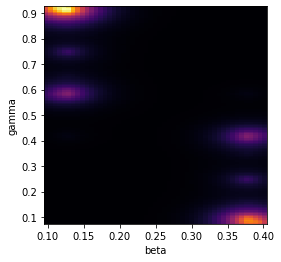

0.1201, 0.9137


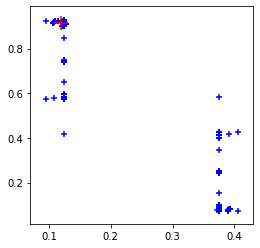


[0.99995595]
[0.99995595]


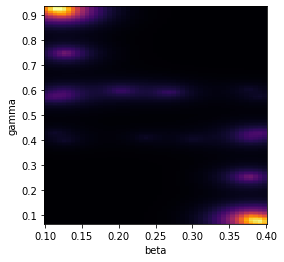

0.1111, 0.9228


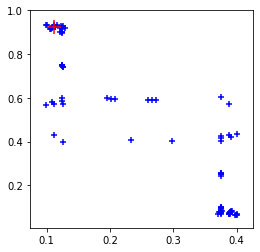

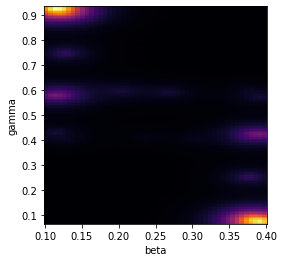

0.1111, 0.9228


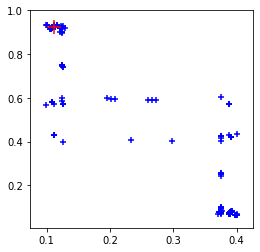


[0.99957882]
[0.99957882]


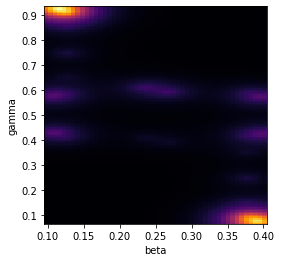

0.1137, 0.9226


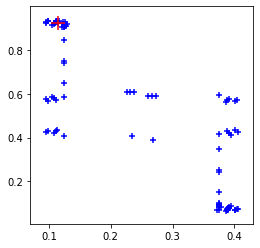

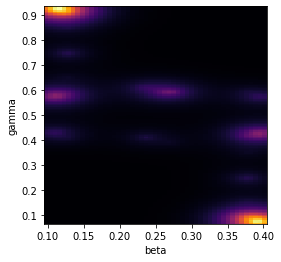

0.1137, 0.9226


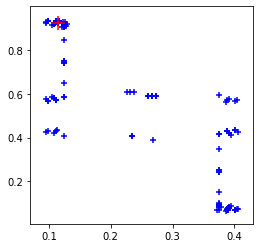


[0.99975609]
[0.99975609]


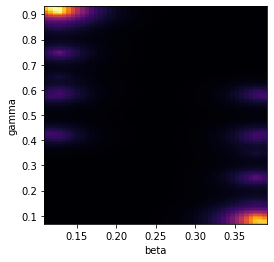

0.1202, 0.9208


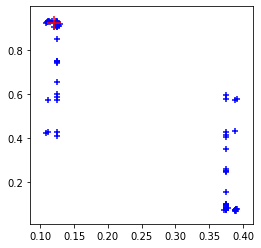

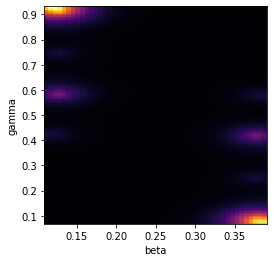

0.1144, 0.9265


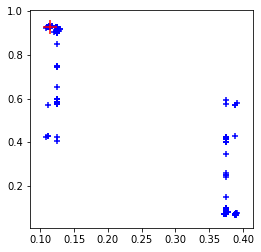


[0.99983346]
[0.99715806]


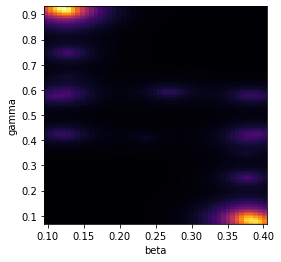

0.1201, 0.9197


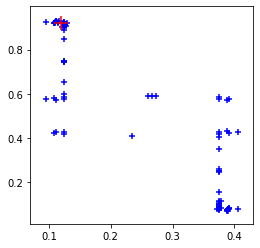

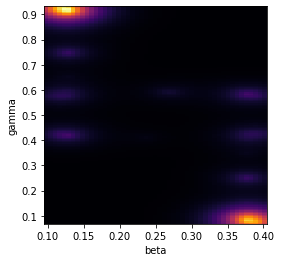

0.1201, 0.9197


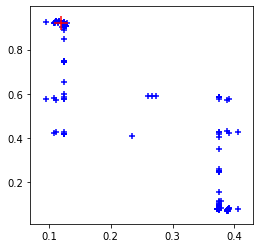


[0.99934576]
[0.99934576]


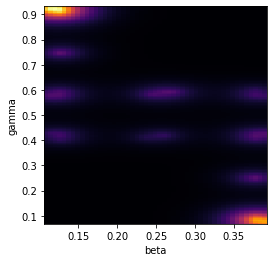

0.1176, 0.9206


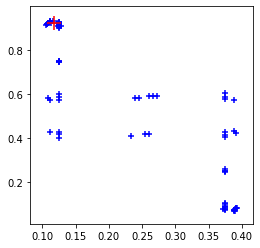

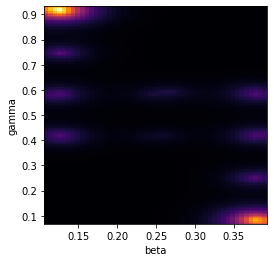

0.1235, 0.9206


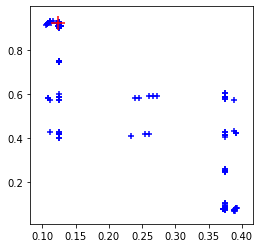


[0.99888169]
[0.99877456]


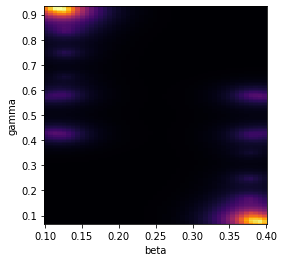

0.1172, 0.9205


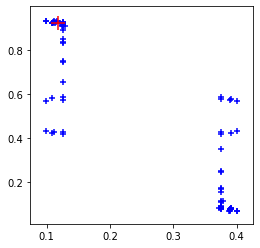

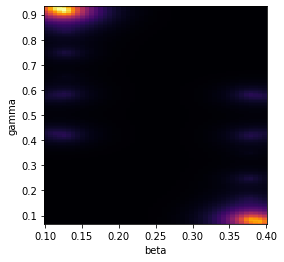

0.1234, 0.9144


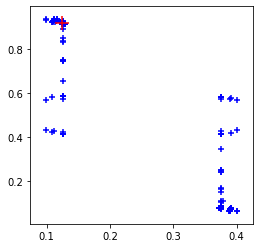


[0.99895999]
[0.99958623]


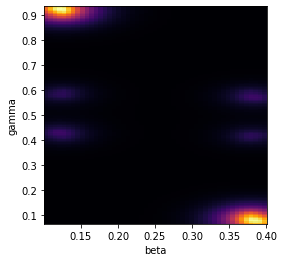

0.1188, 0.9229


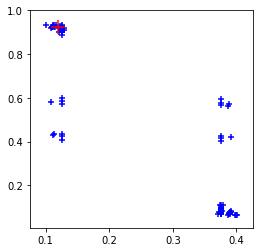

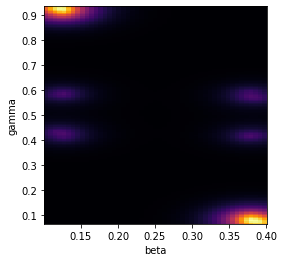

0.3769, 0.0771


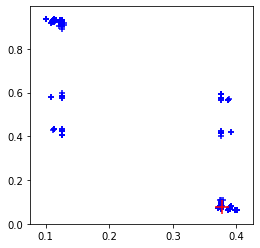


[0.99996907]
[0.99971576]


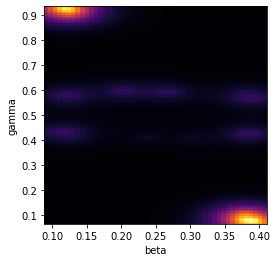

0.3854, 0.0766


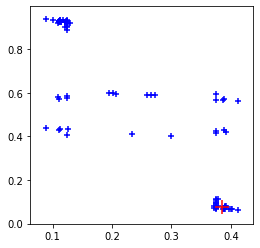

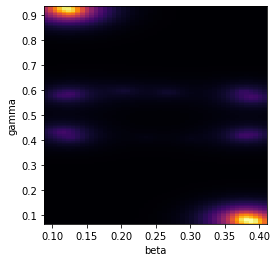

0.3854, 0.0766


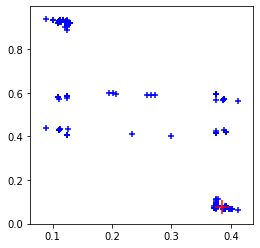


[0.9999545]
[0.9999545]


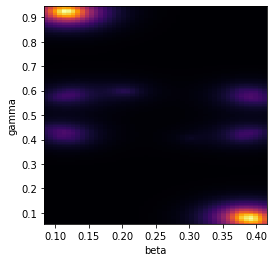

0.1106, 0.9244


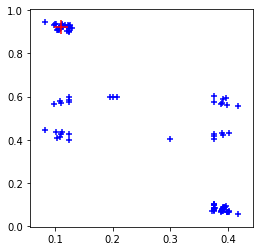

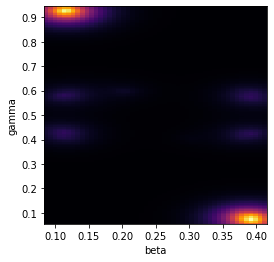

0.3896, 0.0757


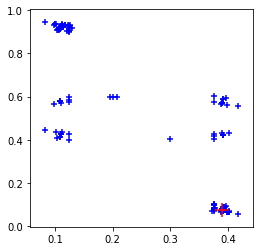


[0.99999693]
[0.99999287]


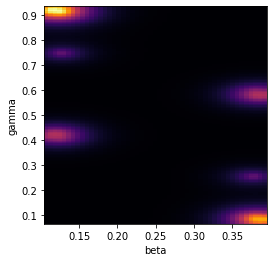

0.1161, 0.9174


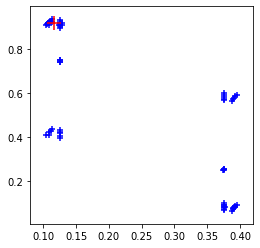

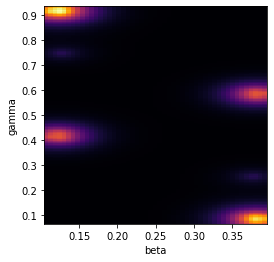

0.1220, 0.9174


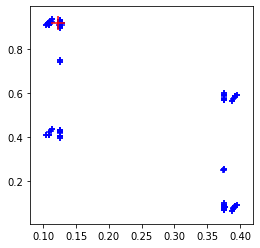


[0.99981033]
[0.99981993]


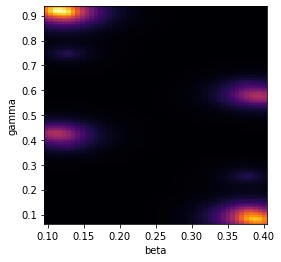

0.1140, 0.9186


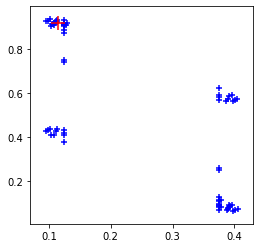

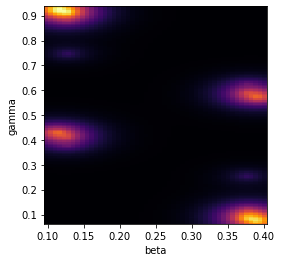

0.1140, 0.9249


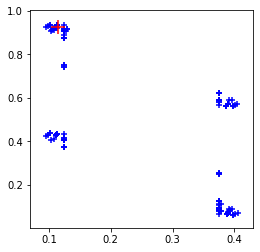


[0.99955866]
[0.99730377]


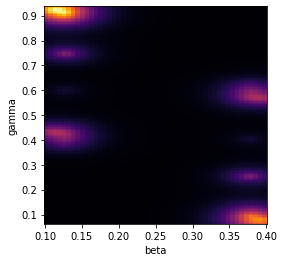

0.1110, 0.9190


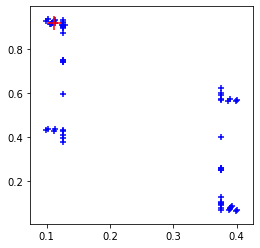

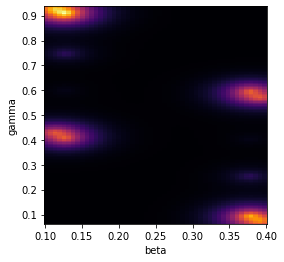

0.1234, 0.9068


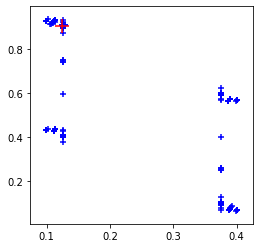


[0.99838845]
[0.99804152]


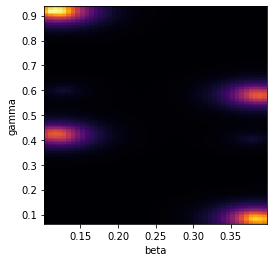

0.1138, 0.9194


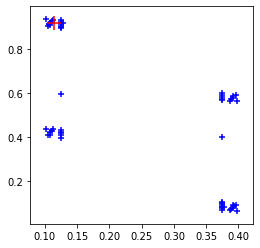

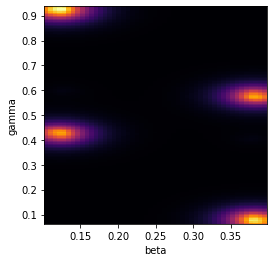

0.1199, 0.9254


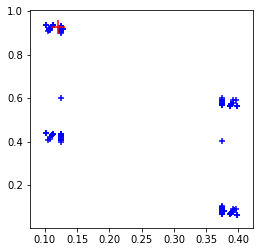


[0.99875182]
[0.99993291]


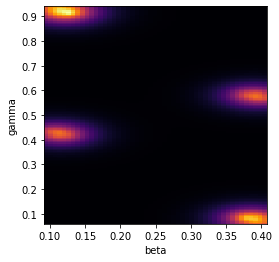

0.1240, 0.9150


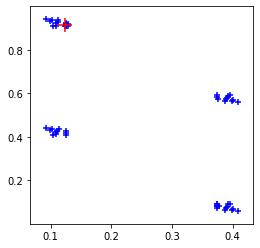

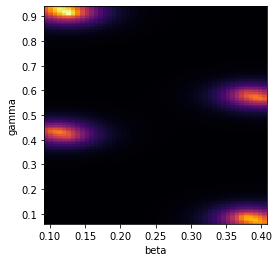

0.1240, 0.9150


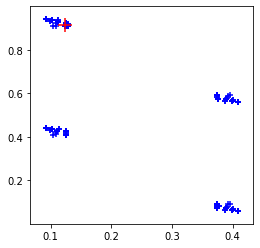


[0.99552125]
[0.99552125]


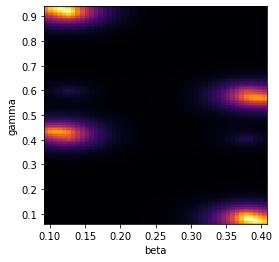

0.3890, 0.0722


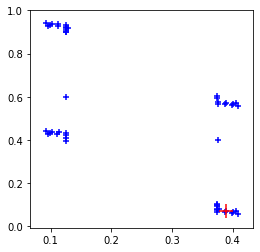

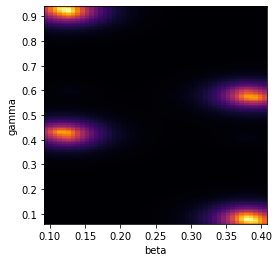

0.3761, 0.0786


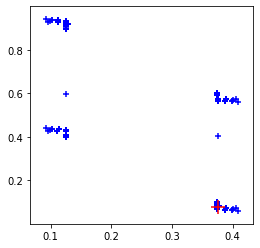


[0.998488]
[0.99916896]


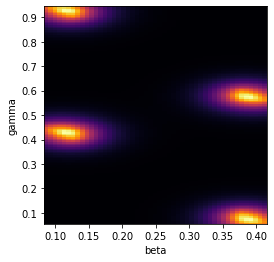

0.1106, 0.4260


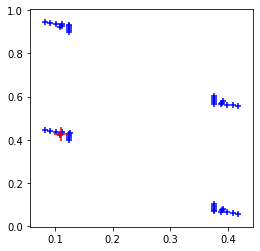

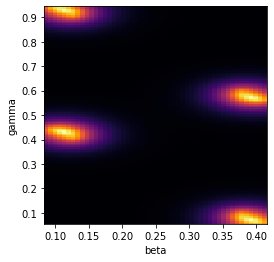

0.1106, 0.9311


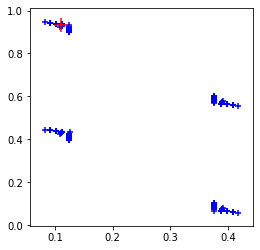


[0.9999332]
[0.99871886]


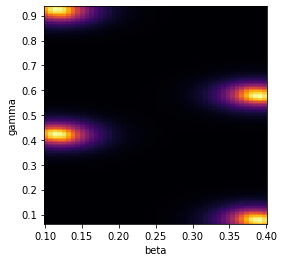

0.3889, 0.5765


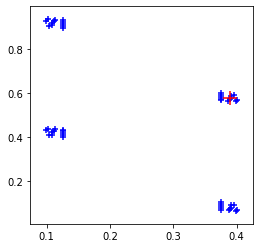

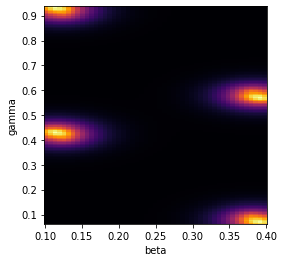

0.3889, 0.5703


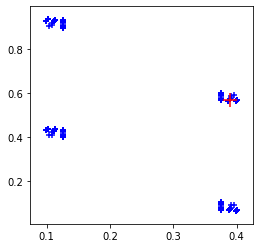


[0.99968287]
[0.99918423]


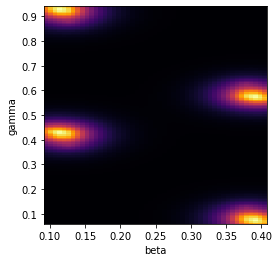

0.3890, 0.0722


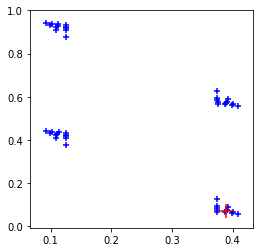

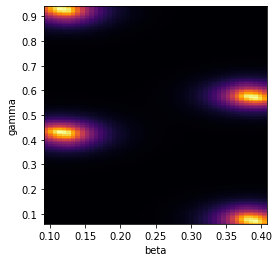

0.1111, 0.9278


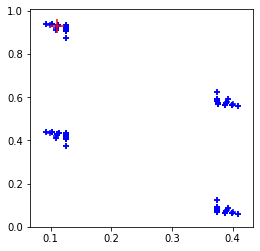


[0.99944926]
[0.99947589]


In [61]:
import math
u= []
w = []
u_angles = []
w_angles = []

for g_idx in range(len(g_list)):
    
    graph = g_list[g_idx]
    ##finding Subgraphs
    master = find_subgraphs(graph)


    #Superposing local optima of subgraphs 
    unw_centers =[]
    w_centers = []
    for sub in master.keys():
        idx = find_index(sub, g_all)
        freq = master[sub]

        for i in range(4):
            center = centers[idx*4 + i]
            unw_centers.append(center)
            for i in range(freq):
                w_centers.append(center)

    #Finding the optimas 

    c = unw_centers
    gamma = [float(c[i][1]) for i in range(len(c))]
    beta = [float(c[i][0]) for i in range(len(c))]
    uw_beta, uw_gamma = max_density_center(beta , gamma)

    c = w_centers
    gamma = [float(c[i][1]) for i in range(len(c))]
    beta = [float(c[i][0]) for i in range(len(c))]
    w_beta, w_gamma = max_density_center(beta , gamma)

    w_approx = approx_ratio(graph,g_idx, w_gamma, w_beta)
    uw_approx = approx_ratio(graph,g_idx, uw_gamma, uw_beta)
    
    u_angles.append([uw_beta, uw_gamma])
    w_angles.append([w_beta, w_gamma])
    
    print(uw_approx)
    print(w_approx)
    
    u.append(uw_approx)
    w.append(w_approx)

Text(0.5, 0, 'Index of Graph')

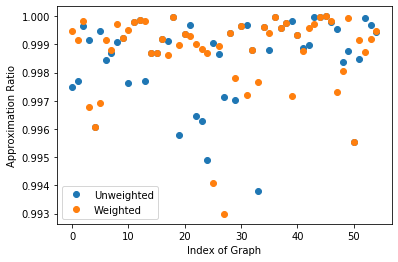

In [62]:
idx = [i for i in range(len(g_list))]
plt.plot(idx, u, linestyle = "", marker = "o", label = "Unweighted")
plt.plot(idx, w, linestyle = "", marker = "o", label = "Weighted")
plt.legend()
plt.ylabel("Approximation Ratio")
plt.xlabel("Index of Graph")

Text(0.5, 0, 'Index of Graph')

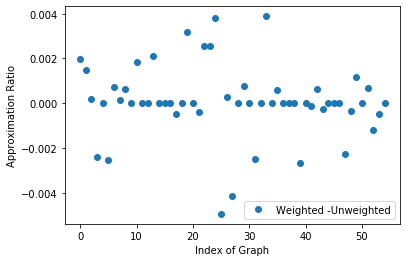

In [63]:
idx = [i for i in range(len(g_list))]
plt.plot(idx, [w[i] - u[i] for i in idx], linestyle = "", marker = "o", label = "Weighted -Unweighted")
plt.legend()
plt.ylabel("Approximation Ratio")
plt.xlabel("Index of Graph")

In [67]:
u = [float(i) for i in u]
u

[0.9974816018405995,
 0.9976875397154927,
 0.9996399600022631,
 0.9991713185831985,
 0.9960575000175503,
 0.9994595969372299,
 0.9984300519736277,
 0.9986836249020643,
 0.9990744940834017,
 0.9992287784188435,
 0.9976316867840064,
 0.9997819072450701,
 0.9998677357304504,
 0.9977052745169643,
 0.9987031201652198,
 0.9986970823610362,
 0.999186736209424,
 0.9991317798607362,
 0.9999562727347923,
 0.9957928639239053,
 0.9993828785964601,
 0.9996988306385013,
 0.9964572830564835,
 0.9962734282904163,
 0.9949142025493335,
 0.9990411574238065,
 0.9986728893073009,
 0.9971211550455669,
 0.9994128257424456,
 0.9970293312907451,
 0.9996361123139108,
 0.9997010173327409,
 0.9987938745315298,
 0.9937883449628266,
 0.9996170222811555,
 0.9987978521521899,
 0.9999559509434032,
 0.999578820880361,
 0.9997560897281895,
 0.9998334623699962,
 0.9993457581133395,
 0.9988816925709983,
 0.9989599855974536,
 0.9999690729059979,
 0.9999545016856614,
 0.9999969296251464,
 0.9998103290777725,
 0.999558661535

In [68]:
w = [float(i) for i in w]
w

[0.9994698283508303,
 0.9991559112090246,
 0.9998335582251708,
 0.9967653124073712,
 0.9960575000175503,
 0.9969072332505302,
 0.9991445345674991,
 0.998807034001345,
 0.9997218608623759,
 0.9992287784188435,
 0.9994933695324854,
 0.9997798854435421,
 0.9998677357304504,
 0.9998184624003462,
 0.9987031201652198,
 0.9986970823610362,
 0.999186736209424,
 0.9986373499430277,
 0.9999562727347923,
 0.9989838490387313,
 0.9993828785964601,
 0.9992923823785272,
 0.9990085970470255,
 0.9988460670049537,
 0.9987081589708708,
 0.9940910553198714,
 0.998941886032426,
 0.9929872268362766,
 0.9994128257424456,
 0.997801121213225,
 0.9996361123139108,
 0.9972191695947344,
 0.9987938745315298,
 0.9976763472062796,
 0.9996170222811555,
 0.9993863270760828,
 0.9999559509434032,
 0.999578820880361,
 0.9997560897281895,
 0.9971580628817546,
 0.9993457581133395,
 0.9987745597605613,
 0.9995862347361072,
 0.9997157573906263,
 0.9999545016856614,
 0.9999928688422537,
 0.999819932368482,
 0.997303774162717,

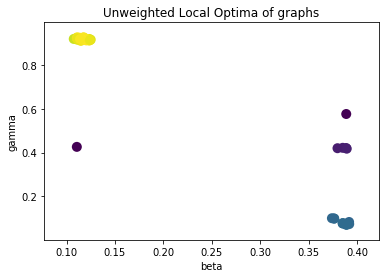

In [139]:
c = u_angles
u_gamma = [float(c[i][1]) for i in range(len(c))]
u_beta = [float(c[i][0]) for i in range(len(c))]

#cm = plt.cm.get_cmap('Reds')

#plt.scatter(beta, gammafrom scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde

fig = plt.figure(figsize = (6,4))
x =u_beta
y = u_gamma

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# fig, ax = plt.subplots()
plt.scatter(x, y, c=z, s=100, edgecolor='')
plt.xlabel("beta")
plt.ylabel("gamma")
plt.title('Unweighted Local Optima of graphs')
plt.show()

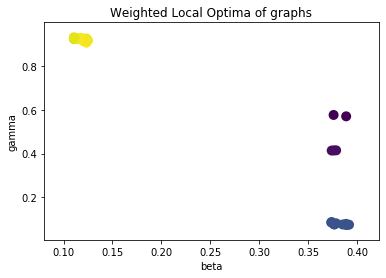

In [141]:
c = w_angles
w_gamma = [float(c[i][1]) for i in range(len(c))]
w_beta = [float(c[i][0]) for i in range(len(c))]

#cm = plt.cm.get_cmap('Reds')

#plt.scatter(beta, gammafrom scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde

fig = plt.figure(figsize = (6,4))
x =w_beta
y = w_gamma

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# fig, ax = plt.subplots()
plt.scatter(x, y, c=z, s=100, edgecolor='')
plt.xlabel("beta")
plt.ylabel("gamma")
plt.title('Weighted Local Optima of graphs')
plt.show()

Text(0, 0.5, 'Euclidean Distance')

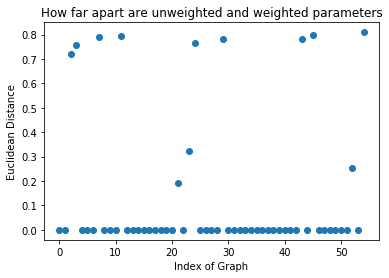

In [143]:
euc_dist = []
for i in idx:
    dist = (u_gamma[i]-w_gamma[i])**2 + (u_beta[i]-w_beta[i])**2
    euc_dist.append(dist)
plt.plot(idx, euc_dist, linestyle = "", marker = "o")
plt.title("How far apart are unweighted and weighted parameters")
plt.xlabel("Index of Graph")
plt.ylabel("Euclidean Distance")

In [ ]:
[0.99,0.98, 0.97]

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)


# fake data
fs = 10  # fontsize
pos = [1, 2, 4, 5, 7, 8]
data = [np.random.normal(0, std, size=100) for std in pos]

In [5]:
data

[array([ 1.04930431,  0.86609917,  0.5511346 ,  1.72807779, -0.64928812,
        -0.47841958,  1.07788511,  0.96881033, -0.80934479, -1.2373891 ,
         1.86011654, -0.30831924,  0.78297055,  0.02152345,  0.71566379,
         1.40146651, -1.12750212,  1.65581822,  1.40096148,  0.20199007,
        -0.96486356,  1.04458851, -0.43105069, -0.4973195 , -0.05911742,
        -1.11460467, -1.22699779, -1.41008819,  1.31086051, -0.51744207,
        -0.01665814,  0.46917225,  0.77677809, -1.88469769, -0.12758733,
        -0.51931744,  0.73514322,  1.34685132,  0.55025505, -0.22905116,
         0.66123163, -0.53636847, -0.48194438,  0.31272356, -3.12183853,
        -1.35847701, -0.14263821, -0.21699693, -0.032868  ,  1.83214468,
         0.35235984,  0.23664513,  1.47854807,  1.55430657, -1.11060898,
         0.82378856,  0.66527469,  0.71476639, -1.23078705,  2.09540213,
        -0.60321948,  1.61355306, -0.25398405, -1.51587877, -0.11722652,
         0.49542836, -0.70259085,  0.39506954, -1.1

In [14]:
data = [0.99,0.98,0.970,.98, 0.97]

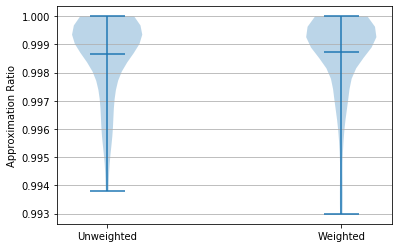

In [75]:
fig, axs = plt.subplots(nrows=1, ncols=1)
axs.violinplot([u,w], [0,1], points=20, widths=0.3,
                     showmeans=True, showextrema=True)# showmedians=True)
axs.set_xticks([0, 1])
axs.yaxis.grid(True)
axs.set_xticklabels(['Unweighted', 'Weighted'])
plt.ylabel("Approximation Ratio")
plt.show()
fig.savefig("fig:SubgraphDecomp_July26.png", dpi = 100)

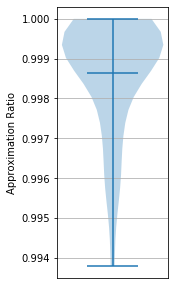

In [76]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (2,5))
axs.violinplot([u], [0], points=20, widths=0.3,
                     showmeans=True, showextrema=True)#, showmedians=True)
axs.set_xticks([])
axs.yaxis.grid(True)
#axs.set_xticklabels([""])
plt.ylabel("Approximation Ratio")
plt.show()
fig.savefig("fig:Unweighted_July26.png", dpi = 100)

In [79]:
%%capture
a = QAOA_energy(g_list[0], [0.5], [0.5])
b= QAOA_energy(g_list[0], [0.5], [0.5])

In [80]:
a

array([15.5])